**Active learning of polarizable nanoparticle phase diagrams for the guided design of triggerable self-assembling superlattices -- Siva Dasetty, Igor Coropceanu, Joshua Portner, Jiyuan Li, Juan J. de Pablo, Dmitri Talapin and Andrew L. Ferguson**

**Notebook to perform active learning (GPyTorch) sampling of the 2-particle phase diagram using umbrella sampling and WHAM**

**Siva Dasetty | [Ferguson lab](www.ferglab.com) | 11/10/20**

In [1]:
# Required modules

import os
import os.path
from os import path

import subprocess

from time import time

import json
import fileinput
import copy
import shutil
from shutil import copyfile

import numpy as np
import pandas as pd
import math
import nglview as ng
import ipywidgets 
import MDAnalysis as md
import mdtraj

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib import rcParams
import matplotlib as mpl
from matplotlib  import cm
from PIL import Image
from matplotlib import colors
import string

# for sklearn version
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern

from scipy.optimize import minimize
from scipy.integrate import simps

import multiprocessing

import torch
from torch import fft
import gpytorch
import gc

import sys
# PyTorch-LBFGS is included with GPyTorch
#sys.path.append("/data/research/self-assembly/nanoparticles/analysis/PyTorch-LBFGS/functions")
#import LBFGS
#from LBFGS import FullBatchLBFGS

import time

ModuleNotFoundError: No module named 'nglview'

In [ ]:
# Global plot settings

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Verdana']
mpl.style.use('seaborn-bright')
#plt.rcParams["text.usetex"] =True

In [ ]:
# path to files

simdir = '/data/research/self-assembly/nanoparticles/2particles/umbrella/'
analysisdir = simdir + 'analysis/'
folderName='stqeieo'

# Check temperature in the simulations

In [ ]:
# Plot distance distribution in each window
folderName='stqeieo'
nbins = 250
thermo_density_edges = {}
col='blue'

incr=8
max_win=21
lower_bound=0
upper_bound=1

for sigma in [10]:
    for t in [0.05, 0.25, 4]:
        for q in [0]:
            for ein in [80]: # [0.08, 80, 800]:
                for eout in [80]:
                    
                    nsx=4
                    nsy=4
                    fig, ax = plt.subplots(nsx, nsy, figsize=[16,8], sharex='none', sharey='none')
                    fig.text(0.075, 0.3, 'Probability density', rotation=90, fontsize=18)
                    fig.text(0.5, 0.01, r'Temperature [$\frac{\epsilon}{k_{B}}$]', fontsize=18, ha='center')
                    plt.subplots_adjust(hspace=0.5)
                    
                    win=1
                    parameters = '_' + str(sigma) + '_' + str(t) + '_' + str(q) + '_' + str(ein) + '_' + str(eout)
                    
                    for j in range(0,nsx):
                        for k in range(0,nsy):

                            ax[j][k].tick_params(axis="x", labelsize=15, direction='in', length=6, width=2, pad=10, colors='black')
                            ax[j][k].tick_params(axis="y", labelsize=15, direction='in', length=6, width=2, colors='black')
                            ax[j][k].xaxis.set_major_locator(plt.MaxNLocator(4))
                        
                            #for i in range(win, win+incr+1):

                                #if i < max_win:
                                    
                            thermo_datafile = simdir + folderName + parameters + '/' + 'thermo' + str(j+k+1) + '.nvt'
                                    #datafile = simdir + folderName + parameters + '/' + 't/' + str(i) + '/node-' + str(i) + '-data.dat'
                            thermo_data = pd.read_csv(thermo_datafile, delimiter = " ", names=["step", "cpu", "te", "ke", "temp", "pe", "vdw", "coul", "press", "vol", "density"], dtype={'step': 'float', 'cpu': 'float', 'te': 'float', 'ke': 'float', 'temp': 'float', 'pe' : 'float', 'vdw': 'float', 'coul': 'float', 'press': 'float', 'vol': 'float', 'density': 'float'}, comment="#")
            
                                    #print(t)
                                    # get density
                            thermo_density_edges[thermo_datafile] = {}
                            thermo_density_edges[thermo_datafile][i] = np.histogram(np.float_(thermo_data.temp.to_numpy()[1:-1]), bins = nbins, density = True)
                            
                            ax[j][k].plot(thermo_density_edges[thermo_datafile][i][1][:-1], thermo_density_edges[thermo_datafile][i][0],color=col,alpha=0.7,lw=1.5,marker='o',markevery=1, markersize=1, label='Window: ' + str(win))
                            ax[j][k].axvline(round(np.mean(thermo_data.temp), 3), lw=3.0, color='black',alpha=0.3)
                            #print(round(np.mean(thermo_data.temp), 3))
                            if i == 1:
                                print(np.min(thermo_density_edges[thermo_datafile][1][1][:-1]))
                    
                            if i == win+incr-1:
                                upper_bound = np.ceil(np.max(thermo_density_edges[thermo_datafile][i][1][:-1]))
                            if i == win:
                                lower_bound = np.floor(np.min(thermo_density_edges[thermo_datafile][i][1][:-1])) 
                                                                    
                                #ax[j][k].set_xlim(lower_bound, upper_bound)
                                #ax[0][0].set_xlim(0, 10)
                            win+=1
                            ax[j][k].legend(fontsize=15, ncol=1, loc='center', frameon=False)
                    #name = '$\sigma^{*}_{NP} = $' + str(sigma) + ', $T^{*}$ = ' + str(t) + ', $q^{*}$ = ' + str(q) + r', $\varepsilon_{in}$ = ' + str(ein) + r', $\varepsilon_{out}$ = ' + str(eout) 
                    #fig.suptitle('Distance distribution in each US window: ' + name, fontsize=18)
                    #plt.show()
                    #plt.savefig('figures/histogram' + parameters +  '.png',  bbox_inches = "tight")
                    #plt.clf()

# Check overlap in Umbrella sampling histograms

9.9947963


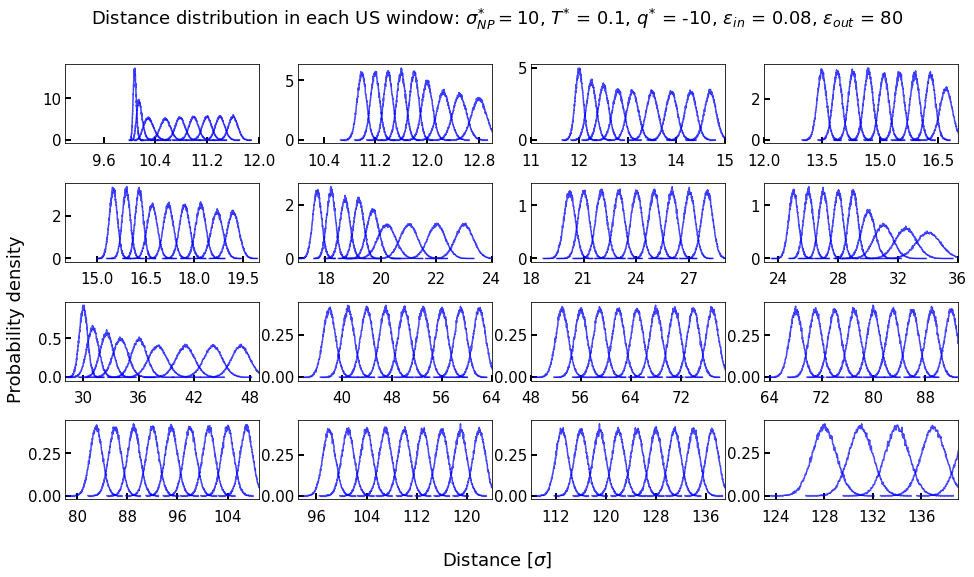

<Figure size 432x288 with 0 Axes>

In [20]:
# Plot distance distribution in each window

kt = 0.592816
kcal=4.184
e=[10*kcal]*15 # for unbiasing each window
r=[10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38] # for unbiasing each window

folderName='stqeieo'
nbins = 250
density_edges = {}
col='blue'

incr=8
max_win=81
lower_bound=10
upper_bound=16

for sigma in [10]:
    for t in [0.1]:
        for q in [-10]:
            for ein in [0.08]: # [0.08, 80, 800]:
                for eout in [80]:
                    
                    nsx=4
                    nsy=4
                    fig, ax = plt.subplots(nsx, nsy, figsize=[16,8], sharex='none', sharey='none')
                    fig.text(0.075, 0.3, 'Probability density', rotation=90, fontsize=18)
                    fig.text(0.5, 0.01, 'Distance [$\sigma$]', fontsize=18, ha='center')
                    plt.subplots_adjust(hspace=0.5)
                    
                    win=1
                    parameters = '_' + str(sigma) + '_' + str(t) + '_' + str(q) + '_' + str(ein) + '_' + str(eout)
                    
                    for j in range(0,nsx):
                        for k in range(0,nsy):

                            ax[j][k].tick_params(axis="x", labelsize=15, direction='in', length=6, width=2, pad=10, colors='black')
                            ax[j][k].tick_params(axis="y", labelsize=15, direction='in', length=6, width=2, colors='black')
                            ax[j][k].xaxis.set_major_locator(plt.MaxNLocator(4))
                        
                            for i in range(win, win+incr+1):

                                if i < max_win:
                                    col='blue'
                                    for a in ['-data.dat']:
                                        datafile = simdir + folderName + parameters + '/' + str(i) + '/node-' + str(i) + a #'-data-900000000.dat'
                                        #datafile = simdir + folderName + parameters + '/' + 't/' + str(i) + '/node-' + str(i) + '-data.dat'
                                        data = pd.read_csv(datafile, delimiter = " ", names=["col1", "col2", "col3"], dtype={'col1': 'float', 'col2': 'float', 'col3': 'float'}, comment="#")
                
                                        #print(datafile)
                                        #print(len(data))
                                        # get density
                                        density_edges[datafile] = {}
                                        density_edges[datafile][i] = np.histogram(np.float_(data.col2.to_numpy()[1:-1]), bins = nbins, density = True)
                                
                                        #np.savetxt('test.txt', density_edges[datafile][i][1][:-1], delimiter='\t')
                                
                                        ax[j][k].plot(density_edges[datafile][i][1][:-1], density_edges[datafile][i][0],color=col,alpha=0.7,lw=1.5,marker='o',markevery=1, markersize=0.1)
                                        col='red'
                                        if i == 1:
                                            print(np.min(density_edges[datafile][1][1][:-1]))
                        
                                        if i == win+incr-1:
                                            upper_bound = np.ceil(np.max(density_edges[datafile][i][1][:-1]))
                                        if i == win:
                                            lower_bound = np.floor(np.min(density_edges[datafile][i][1][:-1])) 
                                                                    
                                ax[j][k].set_xlim(lower_bound, upper_bound)
                                #ax[0][2].set_xlim(13.5, 15.5)
                            win+=5
                   
                    name = '$\sigma^{*}_{NP} = $' + str(sigma) + ', $T^{*}$ = ' + str(t) + ', $q^{*}$ = ' + str(q) + r', $\varepsilon_{in}$ = ' + str(ein) + r', $\varepsilon_{out}$ = ' + str(eout) 
                    fig.suptitle('Distance distribution in each US window: ' + name, fontsize=18)
                    plt.show()
                    #plt.savefig('figures/histogram' + parameters +  '.png',  bbox_inches = "tight")
                    plt.clf()

# Write input files for PMF estimation using WHAM

## [entire data from the simulations] 

In [5]:
# Read JSON files and write input files for WHAM estimation
jsonFilesList0 = ['/multi-umbrella-colloid.json', '/multi1-umbrella-colloid.json', '/multi2-umbrella-colloid.json', '/multi3-umbrella-colloid.json', '/multi4-umbrella-colloid.json', '/multi5-umbrella-colloid.json', '/multi6-umbrella-colloid.json']
jsonFilesList = ['/multi-umbrella-colloid.json', '/multi1-umbrella-colloid.json', '/multi2-umbrella-colloid.json', '/multi3-umbrella-colloid.json']


kT = 0.592816
forceUnitConversion = kT #WHAM calculations in real units

nFiles = 0
# Initial systems
for sigma in [10, 40, 60, 80]:
    for t in [0.05, 0.1, 0.25, 4]:
        for q in [-150, -75, -50, -25, -10, -5, 0]:
            for ein in [0.08, 80, 800, 8000, 80000]: 
                for eout in [80, 800, 8000]:
                    
                    if t == 0.05 and q != 0:
                        jsonFiles = jsonFilesList0
                    else:
                        jsonFiles = jsonFilesList
                    
                    if sigma == 60:
                        if t in [0.05, 4]:
                            continue
                            
                    if q == 0:
                        if sigma == 60:
                            continue
                        if ein in [0.08, 800]:
                            continue
                        if eout in [800, 8000]:
                            continue
                        if t == 0.1:
                            continue
                    
                    if ein in [8000, 80000]:
                        if q in [-150, -75, 0]:
                            continue
                    
                    if ein != 80:
                        if ein == eout:
                            continue
            
                    if eout in [800, 8000]:
                        if sigma == 10:
                            continue
                        if q not in [-50, -25, -10]:
                            continue
                        if ein in [0.08, 8000]:
                            continue
                        if t in [4]:
                            continue
                    
                    simFolder = simdir     
                    simFolder += folderName + '_' + str(sigma)
                    simFolder += '_' + str(t) + '_' + str(q) 
                    simFolder += '_' + str(ein) + '_' + str(eout)
                    
                    metaFileName = folderName + '_' + str(sigma)
                    metaFileName += '_' + str(t) + '_' + str(q) 
                    metaFileName += '_' + str(ein) + '_' + str(eout)
                    
                    metaFile = open(analysisdir + 'metafiles/' + str(metaFileName) + '.txt', "w+")
                    for f in range(len(jsonFiles)):
                        
                        jsonFile = simFolder + jsonFiles[f]
                    
                        for line in fileinput.input(jsonFile, inplace=1):
                            print(line.replace(r'. ]', r' ]'), end=' ')
                        fileinput.close()
                    
                        jsonContent = {}
                        with open(jsonFile) as jsonFileObject:
                            jsonContent = json.load(jsonFileObject)
                        
                        for i in range(len(jsonContent['methods'][0]['ksprings'])):
                            nodeFile = simFolder + '/' + jsonContent['methods'][0]['output_file'][i]
                            center = jsonContent['methods'][0]['centers'][i][0]
                            forceConstant = round(forceUnitConversion*jsonContent['methods'][0]['ksprings'][i][0], 6)
                            metaFile.write(nodeFile + '\t' + str(center) + '\t' + str(forceConstant) + '\n')
                        
                    metaFile.close()
                    nFiles += 1

print("Number of files: %d" % (nFiles))

Number of files: 493


## Same as above but with blocks of size 10E8

In [6]:
# Make copies of metafiles based on number of blocks
maxblock=900000000

nFiles = 0
for sigma in [10, 40, 60, 80]:
    for t in [0.05, 0.1, 0.25, 4]:
        for q in [-150, -75, -50, -25, -10, -5, 0]:
            for ein in [0.08, 80, 800, 8000, 80000]: 
                for eout in [80, 800, 8000]:
                    
                    if sigma == 60:
                        if t in [0.05, 4]:
                            continue
                            
                    if q == 0:
                        if sigma == 60:
                            continue
                        if ein in [0.08, 800]:
                            continue
                        if eout in [800, 8000]:
                            continue
                        if t == 0.1:
                            continue
                    
                    if ein in [8000, 80000]:
                        if q in [-150, -75, 0]:
                            continue
                    
                    if ein != 80:
                        if ein == eout:
                            continue
            
                    if eout in [800, 8000]:
                        if sigma == 10:
                            continue
                        if q not in [-50, -25, -10]:
                            continue
                        if ein in [0.08, 8000]:
                            continue
                        if t in [4]:
                            continue
                    
                    if t == 0.1 or sigma == 60 or ein in [8000, 80000] or eout in [800, 8000]:
                        maxblock = 500000000
                    else:
                        maxblock = 1000000000
                    
                    
                    simFolder = simdir     
                    simFolder += folderName + '_' + str(sigma)
                    simFolder += '_' + str(t) + '_' + str(q) 
                    simFolder += '_' + str(ein) + '_' + str(eout)
                    
                    metaFileName = folderName + '_' + str(sigma)
                    metaFileName += '_' + str(t) + '_' + str(q) 
                    metaFileName += '_' + str(ein) + '_' + str(eout)
                     
                    for block in range(0, maxblock, 100000000):
                        metaFileBlock = open(analysisdir + 'metafiles/' + str(metaFileName) + '-skip-' + str(block) + '.txt', "w")
                        metaFile = open(analysisdir + 'metafiles/' + str(metaFileName) + '.txt', "r")
                    
                    
                        with metaFileBlock as metaFileBlockObject:
                            with metaFile as metaFileObject:
                                metaFileBlockObject.write(metaFileObject.read().replace(r'-data.dat', r'-data-skip-' + str(block) + '.dat'))
                            
                        metaFile.close()
                        metaFileBlock.close() 
                        nFiles += 1
                        
print("Number of files: %d" % (nFiles))

Number of files: 3320


# Run WHAM using Alan Grossfields' code [run shell scripts in analysis folder from terminal]

## Check number of PMF files

In [7]:
maxblock=900000000
n_sim=0
block=0

for sigma in [10, 40, 60, 80]:
    for t in [0.05, 0.1, 0.25, 4]:
        for q in [-150, -75, -50, -25, -10, -5, 0]:
            for ein in [0.08, 80, 800, 8000, 80000]:
                for eout in [80, 800, 8000]:
                    
                    if sigma == 60:
                        if t in [0.05, 4]:
                            continue
                            
                    if q == 0:
                        if sigma == 60:
                            continue
                        if ein in [0.08, 800]:
                            continue
                        if eout in [800, 8000]:
                            continue
                        if t == 0.1:
                            continue
                    
                    if ein in [8000, 80000]:
                        if q in [-150, -75, 0]:
                            continue
                    
                    if ein != 80:
                        if ein == eout:
                            continue
            
                    if eout in [800, 8000]:
                        if sigma == 10:
                            continue
                        if q not in [-50, -25, -10]:
                            continue
                        if ein in [0.08, 8000]:
                            continue
                        if t in [4]:
                            continue
                            
                    if t == 0.1 or sigma == 60 or ein in [8000, 80000] or eout in [800, 8000]:
                        maxblock = 500000000
                    else:
                        maxblock = 1000000000

                    metaFileName = folderName + '_' + str(sigma)
                    metaFileName += '_' + str(t) + '_' + str(q) 
                    metaFileName += '_' + str(ein) + '_' + str(eout)
                     
                    for block in range(0, maxblock, 100000000):
                        pmfFile =analysisdir + 'freefiles/freefile-' + str(metaFileName) + '-skip-' + str(block) + '.txt'
                
                    
                        if path.exists(pmfFile):
                            n_sim += 1
                        else:
                            print(pmfFile)


print("Number of files: %d" % (n_sim))

Number of files: 3320


## PMF profiles [initial plots; full data -- no blocks; skip this -- only for debugging]

In [ ]:
# PMF estimated using WHAM implemented by Alan Grossfield [see header]
def find_min(pmf_data, p_min):
    
    for i in range(0, len(pmf_data)):
        if pmf_data.col1.iloc[i] > pmf_data.col1.max() - 5 and pmf_data.col1.iloc[i] < pmf_data.col1.max():
            if pmf_data.col2.iloc[i] < p_min:
                p_min = pmf_data.col2.iloc[i]

    return p_min

fig, ax = plt.subplots(1, 2, figsize=[20, 4], sharex='none', sharey='none')
fig.suptitle(r'$q_{2}$ = 5, $\frac{q_{1}}{q_{2}}}$ = -20',fontsize=30, y = 1.05)
plt.subplots_adjust(hspace=0.75)

# PMF data from WHAM
folderName='stqeieo'
nbins = 250
kt = 0.592816
density_edges = {}
for sigma in [80]:
    for t in [0.05, 0.25, 4]:
        for q in [-25]:
            for ein in [800]:
                for eout in [80]:

                    pmf_datafile = simdir + 'analysis/freefiles/freefile-' + folderName + '_' + str(sigma) + '_' + str(t) + '_' + str(q) + '_' + str(ein) + '_' + str(eout) + '.txt'
                    pmf_data = pd.read_csv(pmf_datafile, delimiter = "\t", names=["col1", "col2", "col3", "col4", "col5"], comment="#")
           
                    #print(pmf_data.col2)
                    #pd.set_option('display.max_rows', None)
                    #pmf_data = pmf_data[pmf_data.col1 < 135]
                    pmf_data.col2 = pmf_data.col2 + 2*kt*t*np.log(pmf_data.col1)
                    
                    pmf_data = pmf_data[~pmf_data.isin([np.inf]).any(1)]
                    
                    a =  2*kt*t*np.log(pmf_data.col1) #+ 42.5
                    #print(pmf_data.col2)
                
                    pmf_min = 1000
                    pmf_min = find_min(pmf_data, pmf_min)
                    
                    #print(pmf_min)
                    
                    pmf_data.col2 = (pmf_data.col2 - pmf_min)#/(kt)
                    
                    #print(pmf_data[pmf_data.col1 < 15])
                    
                    #print(pmf_data)

                    for i in range(0, 2):
                        ax[i].tick_params(axis="x", labelsize=20, direction='in', length=6, width=2, colors='black')
                        ax[i].tick_params(axis="y", labelsize=20, direction='in', length=6, width=2, colors='black')
                        ax[i].axhline(0, lw=1.0, color='black',alpha=0.5)
                        ax[i].axvline(sigma, lw=1.0, color='black',alpha=0.5) 
                        ax[i].set_xlabel('Distance [$\sigma$]',fontsize=30)
                        
                        #ax[i].plot(pmf_data.col1, pmf_data.col2,alpha=0.7,lw=1.,marker='o',markevery=1, markersize=5, label=r'$\varepsilon_{in}$ =' + str(ein))
                        #ax[i].plot(pmf_data.col1, pmf_data.col2/t ,alpha=0.7,lw=1.,marker='o',markevery=1, markersize=5, label='$q^{*}$ =' + str(q))
                        ax[i].plot(pmf_data.col1, pmf_data.col2, alpha=0.7,lw=1.,marker='o',markevery=1, markersize=5, label='$T^{*}$ =' + str(t))

                        #ax[i].plot(pmf_data.col1, a,alpha=0.7,lw=1.,marker='o',markevery=1, markersize=5, label='$aq{*}$ =' + str(q))
                               
                    #name = '$\sigma^{*}_{NP} = $' + str(sigma) + ', $T^{*}$ = ' + str(t) + r', $\varepsilon_{in}$ = ' + str(ein) + r', $\varepsilon_{out}$ = ' + str(eout)
                    name = '$\sigma^{*}_{NP} = $' + str(sigma) + ', $q^{*}$ = ' + str(q) + r', $\varepsilon_{in}$ = ' + str(ein) + r', $\varepsilon_{out}$ = ' + str(eout)

                    #r', $\varepsilon_{in}$ = ' + str(ein) + 
                    # + ', $q^{*}$ = ' + str(q)
                    fig.suptitle(name, fontsize=18)
                      
                    ax[0].set_ylabel('PMF [$\epsilon$T$^{*}$]',fontsize=30, labelpad=15)
                    ax[1].legend(fontsize=15, ncol=3, loc='lower right', frameon=False)
                    #ax[1].legend(fontsize=15, ncol=1, loc='center', frameon=False)

                    ax[1].set_xlim(39,45)
                    #ax[1].set_ylim(-20,5)


                    #fig_parameters = '_' + str(sigma) + '_' + str(t) + '_' + str(q) + '_' + str(eout)
                    
                    fig_parameters = '_' + str(sigma) + '_' + str(t) + '_' + str(ein) + '_' + str(eout)

        #plt.show()
                    #plt.savefig('figures/pmf' + fig_parameters + '-ein.png', bbox_inches = "tight")
                    #plt.savefig('figures/pmf' + fig_parameters + '-q.png', bbox_inches = "tight")
        #plt.clf()

## Average and standard deviation of PMF profiles. Estimated using block average approach.  (Checking entropy correction and unit conversions.)

In [ ]:
# PMF estimated using WHAM implemented by Alan Grossfield [see header]
def find_min(pmf_data, p_min):
    
    for i in range(0, len(pmf_data)):
        if pmf_data.col1.iloc[i] > pmf_data.col1.max() - 5 and pmf_data.col1.iloc[i] < pmf_data.col1.max():
            if pmf_data.col2.iloc[i] < p_min:
                p_min = pmf_data.col2.iloc[i]

    return p_min

def find_min_avg(pmf_x, pmf_data, p_min):
    
    for i in range(0, len(pmf_x)):
        if pmf_x.iloc[i] > pmf_x.max() - 5  and pmf_x.iloc[i] < pmf_x.max():
            if pmf_data.iloc[i] < p_min:
                p_min = pmf_data.iloc[i]

    return p_min


fig, ax = plt.subplots(3, 2, figsize=[20, 15], sharex='none', sharey='none')
plt.subplots_adjust(hspace=0.15)

# PMF data from WHAM
folderName='stqeieo'
nbins = 250
kt = 0.592816
density_edges = {}
maxblock=900000000
block=0

for sigma in [40]: #, 40, 60, 80]:
    for t in [0.05, 0.1, 0.25 , 4]:
        for q in [-10]: #, -75, -50, -25, -10, -5, 0]:
            for ein in [0.08]: #, 80, 800]:
                for eout in [80]: #, 800, 8000]:
                    
                    if sigma == 60:
                        if t in [0.05, 4]:
                            continue
                            
                    if q == 0:
                        if sigma == 60:
                            continue
                        if ein in [0.08, 800]:
                            continue
                        if eout in [800, 8000]:
                            continue
                        if t == 0.1:
                            continue
                    
                    if ein in [8000, 80000]:
                        if q in [-150, -75, 0]:
                            continue
                    
                    if ein != 80:
                        if ein == eout:
                            continue
            
                    if eout in [800, 8000]:
                        if sigma == 10:
                            continue
                        if q not in [-50, -25, -10]:
                            continue
                        if ein in [0.08, 8000]:
                            continue
                        if t in [4]:
                            continue
                            
                    if t == 0.1 or sigma == 60 or ein in [8000, 80000] or eout in [800, 8000]:
                        maxblock = 500000000
                    else:
                        maxblock = 1000000000
                    
                    metaFileName = folderName + '_' + str(sigma)
                    metaFileName += '_' + str(t) + '_' + str(q) 
                    metaFileName += '_' + str(ein) + '_' + str(eout)
                    
                    #full_pmf_datafile = simdir + #'analysis/freefiles/freefile-' + folderName + '_' + str(sigma) + '_' + str(t) + '_' + str(q) + '_' + str(ein) + '_' + str(eout) + '.txt'
                    #full_pmf_data = pd.read_csv(full_pmf_datafile, delimiter = "\t", names=["col1", "col2", "col3", "col4", "col5"], comment="#")
                    #full_pmf_data.col2 = full_pmf_data.col2 + 2*kt*t*np.log(full_pmf_data.col1)
                    #full_pmf_data = full_pmf_data[~full_pmf_data.isin([np.inf]).any(1)]
                    #full_pmf_min = 1000
                    #full_pmf_min = find_min(full_pmf_data, full_pmf_min)
                    #full_pmf_data.col2 = (full_pmf_data.col2 - full_pmf_min)/(kt*t)
                                                          
                    pmf_df = None
                    pmf_dfSCorr = None
                    pmf_x = None
                     
                    for block in range(0, maxblock, 100000000):
                        pmf_datafile =analysisdir + 'freefiles/freefile-' + str(metaFileName) + '-skip-' + str(block) + '.txt'
                        pmf_data = pd.read_csv(pmf_datafile, delimiter = "\t", names=["col1", "col2", "col3", "col4", "col5"], comment="#", skiprows=0)
                        
                        pmf_dataSCorr = pmf_data.copy()
                        pmf_data.col2 = pmf_data.col2 + 2*kt*t*np.log(pmf_data.col1) 
                        
                        #pmf_data = pmf_data[~pmf_data.isin([np.inf]).any(1)]
                        #pmf_data.col2 -= pmf_data.col2.mean()
                        
                        pmf_df = pmf_data.col2 if pmf_df is None else pd.concat([pmf_df, pmf_data.col2], axis=1)
                        pmf_dfSCorr = pmf_dataSCorr.col2 if pmf_dfSCorr is None else pd.concat([pmf_dfSCorr, pmf_dataSCorr.col2], axis=1)
                        
                        if block == 0:
                            pmf_x = pmf_data.col1
                    
                    number_of_columns= len(pmf_df.columns)
                    #print(number_of_columns)
                    
                    pmf_df2 = None
                    pmf_df2SCorr = None
                    pmd_df3 = None
                    
                    pmf_df3 = pd.concat([pmf_df, pmf_x], axis=1)
                    pmf_df3 = pmf_df3[~pmf_df3.isin([np.inf]).any(1)]
                    pmf_x = pmf_df3.col1
                    
                    pmf_df = pmf_df[~pmf_df.isin([np.inf]).any(1)]
                    pmf_dfSCorr = pmf_dfSCorr[~pmf_dfSCorr.isin([np.inf]).any(1)]
                    
                    for i in range (0,number_of_columns):
                        df1 = pmf_df.iloc[:,i] + (pmf_df.mean(axis=1) - pmf_df.iloc[:,i]).mean()
                        df1SCorr = pmf_dfSCorr.iloc[:,i] + (pmf_dfSCorr.mean(axis=1) - pmf_dfSCorr.iloc[:,i]).mean()
                        #print( (pmf_df.mean(axis=1) - pmf_df.iloc[:,i])) #.mean() )
                        #print( pmf_df.iloc[:,i] )
                        #print( (pmf_df.mean(axis=1) - pmf_df.iloc[:,i]) )
                        #print((pmf_df.iloc[:,0] - pmf_df.iloc[:,i]))
                        pmf_df2 = df1 if pmf_df2 is None else pd.concat([pmf_df2, df1], axis=1)
                        pmf_df2SCorr = df1SCorr if pmf_df2SCorr is None else pd.concat([pmf_df2SCorr, df1SCorr], axis=1)
                    #pmf_df2 = pmf_df - pmf_df.mean(axis=1) #.mean()
                    #ax[0][0].plot(pmf_x, pmf_df2/t, alpha=0.7,lw=3.,marker='o',markevery=1, markersize=2.5, label=str(i))

                    #print(pmf_df2)
                    pmf_min = 1000
                    pmf_min = find_min_avg(pmf_x, pmf_df2.mean(axis=1), pmf_min)
                    pmf_avg = (pmf_df2.mean(axis=1) - pmf_min)/(kt)
                    
                    pmf_min = 1000
                    pmf_min = find_min_avg(pmf_x, pmf_df2SCorr.mean(axis=1), pmf_min)
                    pmf_min = 0
                    pmf_avgSCorr = (pmf_df2SCorr.mean(axis=1) - pmf_min)/(kt)
                        
                    #print(pmf_avg)
                    #print(pmf_df2) #.std(axis=1))
                    
                    #a =  2*kt*t*np.log(full_pmf_data.col1) #+ 42.5

                    # plot block average and standard deviation
                    for i in range(0, 3):
                        for j in range(0,2):
                            ax[i][j].tick_params(axis="x", labelsize=20, direction='in', length=6, width=2, colors='black')
                            ax[i][j].tick_params(axis="y", labelsize=20, direction='in', length=6, width=2, colors='black')
                            ax[i][j].axhline(0, lw=1.0, color='black',alpha=0.5)
                            ax[i][j].axvline(sigma, lw=1.0, color='black',alpha=0.5) 

                    ax[0][0].errorbar(pmf_x, pmf_avgSCorr/t, yerr=pmf_df2SCorr.std(axis=1),alpha=0.7,lw=2.,marker='o',markevery=1, elinewidth=2, capsize=2, markersize=1, label='$T^{*}$ =' + str(t))
                    ax[0][1].plot(pmf_x, 2*t*np.log(pmf_x), alpha=0.7,lw=2.,marker='o',markevery=1, markersize=1, label='$T^{*}$ =' + str(t))
                    for j in range(0,2):
                        ax[0][j].text(0.05, 2.05, '(' + string.ascii_lowercase[j] + ')', transform=ax[1][j].transAxes, size=20)
                        
                    for j in range(0, 2): 
                        ax[1][j].errorbar(pmf_x, pmf_avg, yerr=pmf_df2.std(axis=1)/t,alpha=0.7,lw=2.,marker='o',markevery=1, elinewidth=2, capsize=2, markersize=1, label='$T^{*}$ =' + str(t))
                        ax[1][j].text(0.05, 0.9,'(' + string.ascii_lowercase[j+2] + ')', transform=ax[1][j].transAxes, size=20)
                        
                    for j in range(0, 2):
                        ax[2][j].errorbar(pmf_x, pmf_avg/t, yerr=pmf_df2.std(axis=1)/t,alpha=0.7,lw=2.,marker='o',markevery=1, elinewidth=2, capsize=2, markersize=1, label='$T^{*}$ =' + str(t))
                        ax[2][j].text(0.05, 0.9,'(' + string.ascii_lowercase[j+4] + ')', transform=ax[2][j].transAxes, size=20)
                               
                    #name = '$\sigma^{*}_{NP} = $' + str(sigma) + ', $T^{*}$ = ' + str(t) + r', $\varepsilon_{in}$ = ' + str(ein) + r', $\varepsilon_{out}$ = ' + str(eout)
                    name = '$\sigma^{*}_{NP} = $' + str(sigma) + ', $q^{*}$ = ' + str(q) + r', $\varepsilon_{in}$ = ' + str(ein) + r', $\varepsilon_{out}$ = ' + str(eout)
                    #name = '$\sigma^{*}_{NP} = $' + str(sigma) + ', $T^{*}$ = ' + str(t) + r', $q^{*}$ = ' + str(q) + r', $\varepsilon_{out}$ = ' + str(eout)
                   # name = '$\sigma^{*}_{NP} = $' + str(sigma) + ', $T^{*}$ = ' + str(t) + r', $q^{*}$ = ' + str(q) + r', $\varepsilon_{in}$ = ' + str(ein)
                    
                    ##r', $\varepsilon_{in}$ = ' + str(ein) + 
                    ## + ', $q^{*}$ = ' + str(q)
                    fig.suptitle(name, fontsize=25, y=0.925)

                    ax[0][0].set_ylabel('PMF [$\epsilon$]',fontsize=30)
                    ax[0][1].set_ylabel('2log(x) [$\epsilon$]',fontsize=30)
                    ax[1][0].set_ylabel('PMF [$\epsilon$]',fontsize=30, labelpad=15)
                    ax[2][0].set_ylabel('PMF [$\epsilon$T$^{*}$]',fontsize=30, labelpad=15)
                    #fig.text(0.08, 0.45, 'PMF [$\epsilon$T$^{*}$]', rotation=90, fontsize=30)
                    fig.text(0.5, 0.05, 'Distance [$\sigma$]', fontsize=30, ha='center')
                    ax[1][1].legend(fontsize=18, ncol=1, loc='lower right', frameon=False)
                    #ax[0][0].legend(fontsize=18, ncol=1, loc='lower right', frameon=False)
                    #ax[1].legend(fontsize=15, ncol=1, loc='center', frameon=False)
    
    
                    for i in range(1,3):
                        ax[i][1].set_xlim(39.5,43.5)
                    #ax[1][0].set_ylim(-0.25,0.25)
                    #ax[1][1].set_ylim(-1.5,0.5)
                    #ax[0][0].set_xlim(39,75)
                    #ax[1][0].set_xlim(12.5,)


                    #parameters = '_' + str(sigma) + '_' + str(t) + '_' + str(q) + '_' + str(eout)
                    #parameters = '_' + str(sigma) + '_' + str(t) + '_' + str(q) + '_' + str(ein)
                    parameters = '_' + str(sigma) + '_' + str(q) + '_' + str(ein) + '_' + str(eout)
                    #parameters = '_' + str(sigma) + '_' + str(t) + '_' + str(ein) + '_' + str(eout)

                    #plt.show()
                    #plt.savefig('pmf' + parameters + '-ein.png', bbox_inches = "tight")
                    #plt.savefig('figures/pmf' + parameters + '-eout2.png', bbox_inches = "tight")
                    #plt.savefig('figures/pmf' + parameters + '-q.png', bbox_inches = "tight")
                    #plt.savefig('figures/pmf' + parameters + '-t.png', bbox_inches = "tight")
                    #plt.clf()

## Average and standard deviation of PMF profiles. Estimated using block average approach.

In [ ]:
# PMF estimated using WHAM implemented by Alan Grossfield [see header]
def find_min(pmf_data, p_min):
    
    for i in range(0, len(pmf_data)):
        if pmf_data.col1.iloc[i] > pmf_data.col1.max() - 5 and pmf_data.col1.iloc[i] < pmf_data.col1.max():
            if pmf_data.col2.iloc[i] < p_min:
                p_min = pmf_data.col2.iloc[i]

    return p_min

def find_min_avg(pmf_x, pmf_data, p_min):
    
    for i in range(0, len(pmf_x)):
        if pmf_x.iloc[i] > pmf_x.max() - 5  and pmf_x.iloc[i] < pmf_x.max():
            if pmf_data.iloc[i] < p_min:
                p_min = pmf_data.iloc[i]

    return p_min

fig, ax = plt.subplots(1, 2, figsize=[20, 6], sharex='none', sharey='none')
plt.subplots_adjust(hspace=0.15)

colors=['b','g','r']
# PMF data from WHAM
folderName='stqeieo'
nbins = 250
kt = 0.592816
density_edges = {}
maxblock=500000000
block=0

for sigma in [10]: #, 40, 60, 80]:
    for t in [0.25, 4]:
        for q in [-5, -75]: #, -75, -50, -25, -10, -5, 0]:
            for ein in [80]: #, 80, 800]: #, 799763.61]: #, 80, 800]:
                for eout in [80]: #, 800, 8000]:
                    
                    #if ein in [0.08, 800, 80]:
                    #    q = -75
                    #else:
                    #    q = '-75.0'
                    
                    if sigma == 60:
                        if t in [0.05, 4]:
                            continue
                            
                    if q == 0:
                        if sigma == 60:
                            continue
                        if ein in [0.08, 800]:
                            continue
                        if eout in [800, 8000]:
                            continue
                        if t == 0.1:
                            continue
                    
                    if ein in [8000, 80000]:
                        if q in [-150, -75, 0]:
                            continue
                    
                    if ein != 80:
                        if ein == eout:
                            continue
            
                    if eout in [800, 8000]:
                        if sigma == 10:
                            continue
                        if q not in [-50, -25, -10]:
                            continue
                        if ein in [0.08, 8000]:
                            continue
                        if t in [4]:
                            continue
                            
                    if t == 0.1 or sigma == 60 or ein in [8000, 80000] or eout in [800, 8000]:
                        maxblock = 500000000
                    else:
                        maxblock = 500000000
                    
                    metaFileName = folderName + '_' + str(sigma)
                    metaFileName += '_' + str(t) + '_' + str(q) 
                    metaFileName += '_' + str(ein) + '_' + str(eout)
                    
                    #full_pmf_datafile = simdir + #'analysis/freefiles/freefile-' + folderName + '_' + str(sigma) + '_' + str(t) + '_' + str(q) + '_' + str(ein) + '_' + str(eout) + '.txt'
                    #full_pmf_data = pd.read_csv(full_pmf_datafile, delimiter = "\t", names=["col1", "col2", "col3", "col4", "col5"], comment="#")
                    #full_pmf_data.col2 = full_pmf_data.col2 + 2*kt*t*np.log(full_pmf_data.col1)
                    #full_pmf_data = full_pmf_data[~full_pmf_data.isin([np.inf]).any(1)]
                    #full_pmf_min = 1000
                    #full_pmf_min = find_min(full_pmf_data, full_pmf_min)
                    #full_pmf_data.col2 = (full_pmf_data.col2 - full_pmf_min)/(kt*t)
                                                          
                    pmf_df = None
                    pmf_dfSCorr = None
                    pmf_x = None
                     
                    for block in range(0, maxblock, 100000000):
                        
                        pmf_datafile =analysisdir + 'freefiles/freefile-' + str(metaFileName) + '-skip-' + str(block) + '.txt'
                        pmf_data = pd.read_csv(pmf_datafile, delimiter = "\t", names=["col1", "col2", "col3", "col4", "col5"], comment="#", skiprows=0)
                        
                        pmf_dataSCorr = pmf_data.copy()
                        pmf_data.col2 = pmf_data.col2 + 2*kt*t*np.log(pmf_data.col1) 
                        
                        pmf_df = pmf_data.col2 if pmf_df is None else pd.concat([pmf_df, pmf_data.col2], axis=1)
                        pmf_dfSCorr = pmf_dataSCorr.col2 if pmf_dfSCorr is None else pd.concat([pmf_dfSCorr, pmf_dataSCorr.col2], axis=1)
                        
                        if block == 0:
                            pmf_x = pmf_data.col1
                    
                    number_of_columns= len(pmf_df.columns)
                    #print(number_of_columns)
                    
                    pmf_df2 = None
                    pmf_df2SCorr = None
                    pmd_df3 = None
                    
                    pmf_df3 = pd.concat([pmf_df, pmf_x], axis=1)
                    pmf_df3 = pmf_df3[~pmf_df3.isin([np.inf]).any(1)]
                    pmf_x = pmf_df3.col1 #[pmf_df3.columns[-1]]
                    
                    pmf_df = pmf_df[~pmf_df.isin([np.inf]).any(1)]
                    pmf_dfSCorr = pmf_dfSCorr[~pmf_dfSCorr.isin([np.inf]).any(1)]
                    
                    for i in range (0,number_of_columns):
                        df1 = pmf_df.iloc[:,i] + (pmf_df.mean(axis=1) - pmf_df.iloc[:,i]).mean()
                        df1SCorr = pmf_dfSCorr.iloc[:,i] + (pmf_dfSCorr.mean(axis=1) - pmf_dfSCorr.iloc[:,i]).mean()

                        pmf_df2 = df1 if pmf_df2 is None else pd.concat([pmf_df2, df1], axis=1)
                        pmf_df2SCorr = df1SCorr if pmf_df2SCorr is None else pd.concat([pmf_df2SCorr, df1SCorr], axis=1)

                    #print(pmf_df2)
                    pmf_min = 1000
                    pmf_min = find_min_avg(pmf_x, pmf_df2.mean(axis=1), pmf_min)
                    pmf_avg = (pmf_df2.mean(axis=1) - pmf_min)/(kt)
                    
                    pmf_min = 1000
                    pmf_min = find_min_avg(pmf_x, pmf_df2SCorr.mean(axis=1), pmf_min)
                    pmf_min = 0
                    pmf_avgSCorr = (pmf_df2SCorr.mean(axis=1) - pmf_min)/(kt)

                    # plot block average and standard deviation
                    for i in range(0, 2):
                        
                        ax[i].tick_params(axis="x", labelsize=40, direction='in', length=6, width=2, colors='black')
                        ax[i].tick_params(axis="y", labelsize=40, direction='in', length=6, width=2, colors='black')
                        #ax[i].axhline(0, lw=1.0, color='black',alpha=0.5)
                        #ax[i].axvline(sigma, lw=1.0, color='black',alpha=0.5) 
 
                    #if t == 0.05:
                    #    colors_index += 1
                    #    continue
                        #ax[i].errorbar(pmf_x, pmf_avg/t, yerr=pmf_df2.std(axis=1)/t,alpha=0.7,lw=4.,marker='o', markevery=1, elinewidth=2, capsize=2, markersize=1, label='$T^{*}$ =' + str(t))
                        #ax[i].errorbar(pmf_x, pmf_avg/t, yerr=pmf_df2.std(axis=1)/t,alpha=0.7,lw=4.,marker='o',c=colors[colors_index], markevery=1, elinewidth=2, capsize=2, markersize=1, label=r'$\varepsilon_{out}$ =' + str(eout))
                        #ax[i].errorbar(pmf_x, pmf_avg/t, yerr=pmf_df2.std(axis=1)/t,alpha=0.7,lw=4.,marker='o',c=colors[colors_index], markevery=1, elinewidth=2, capsize=2, markersize=1, label=r'$\sigma_{NP}^{*}$ =' + str(sigma))
                        ax[i].errorbar(pmf_x, pmf_avg/t, yerr=pmf_df2.std(axis=1)/t,alpha=0.7,lw=4.,marker='o', markevery=1, elinewidth=2, capsize=2, markersize=1, label=r'$q^{*}$ = ' + str(q) + r', $T^{*}$ = ' + str(t) )
                        
                        #name = '$\sigma^{*}_{NP} = $' + str(sigma) + ', $q^{*}$ = ' + str(q) + r', $\varepsilon_{in}$ = ' + str(ein) + r', $\varepsilon_{out}$ = ' + str(eout)
                        #name = '$\sigma^{*}_{NP} = $' + str(sigma) + ', $q^{*}$ = ' + str(q) + r', $T^{*}$ = ' + str(t) + r', $\varepsilon_{out}$ = ' + str(eout)
                        #name = '$\sigma^{*}_{NP} = $' + str(sigma) + ', $q^{*}$ = ' + str(q) + r', $T^{*}$ = ' + str(t) + r', $\varepsilon_{in}$ = ' + str(ein)
                        #name = '$q^{*}$ = ' + str(q) + r', $T^{*}$ = ' + str(t) + r', $\varepsilon_{in}$ = ' + str(ein) + r', $\varepsilon_{out}$ = ' + str(eout)

                        name = '$\sigma^{*}_{NP} = $' + str(sigma) + r', $\varepsilon_{in}$ =' + str(round(ein,2)) + r', $\varepsilon_{out}$ = ' + str(eout)


                        ax[i].set_xlabel('Distance [$\sigma$]', fontsize=50, labelpad=15)
                    
                    ax[0].set_ylabel('PMF [$\epsilon$T$^{*}$]',fontsize=50, labelpad=15)

                    ax[0].legend(fontsize=15, ncol=1, loc='upper right', frameon=False)
                        #ax[0][0].legend(fontsize=18, ncol=1, loc='lower right', frameon=False)
                    #ax[1].legend(fontsize=15, ncol=1, loc='upper right', frameon=False)
                    
                    #10	0.25	0	80	80	-1.893047102323233	0.23119598567190064
                    #10	0.25	-5	80	80	-1.7066335655957505	0.4672435937667283
                    ax[1].axhline(-1.7066335655957505,0, 1, color='blue', lw=5, alpha=0.5, ls=':', label=r'$\Delta$ A')
                    #10	4	0	80	80	-0.16920162141684628	0.5742727818846026
                    #10	4	-5	0.08	80	0.22418867882612373	0.8785421509101602
                    ax[1].axhline(0.22418867882612373, 0, 1, color='red', lw=5, alpha=0.5, ls=':')
                    #10	0.25	-75	80	80	23.23213495861297	0.5393086080856296
                    ax[1].axhline(23.23213495861297, 0, 1, color='green', lw=5, alpha=0.5, ls=':')
                    #10	4	-75	80	80	1.7748221850283368	0.8779832243285669
                    ax[1].axhline(1.7748221850283368, 0, 1, color='purple', lw=5, alpha=0.5, ls=':')
                    
                    
                    
        
    
                    ax[1].set_xlim(9.75, 12.5)

                    fig.suptitle(name, fontsize=25, y=0.975)
                    
                    #fig_parameters = '_' + str(sigma) + '_' + str(q) + '_' + str(ein) + '_' + str(t)

                    fig_parameters = '_' + str(sigma) + '_' + str(q) + '_' + str(ein) + '_' + str(eout)
                    
                    #fig_parameters = '_' + str(t) + '_' + str(q) + '_' + str(ein) + '_' + str(eout)
                    #plt.grid()

                    #plt.show()
                    #plt.savefig('figures-2/singlepmf' + fig_parameters + '.png', bbox_inches = "tight")
                    #plt.savefig('singlepmf' + fig_parameters + '.png', bbox_inches = "tight")

                    #plt.clf()

# Estimate average and SD of $\Delta$A

In [10]:
# PMF estimated using WHAM implemented by Alan Grossfield [see header]
def find_min(pmf_data, p_min):
    
    for i in range(0, len(pmf_data)):
        if pmf_data.col1.iloc[i] > pmf_data.col1.max() - 5 and pmf_data.col1.iloc[i] < pmf_data.col1.max():
            if pmf_data.col2.iloc[i] < p_min:
                p_min = pmf_data.col2.iloc[i]

    return p_min

# PMF data from WHAM
folderName='stqeieo'
kt = 0.592816

free_energy = []
parameters = []

sigma_list = [80]
t_list = [0.05, 0.1, 0.25, 4]
q_list = [-150, -75, -50, -25, -10, -5, 0]
ein_list = [0.08, 80, 800, 8000, 80000]
eout_list = [80, 800, 8000]

maxblock=900000000
block=0

for sigma in sigma_list:
    for t in t_list:
        for q in q_list:
            for ein in ein_list:
                for eout in eout_list:
                    
                    if sigma == 60:
                        if t in [0.05, 4]:
                            continue
                            
                    if q == 0:
                        if sigma == 60:
                            continue
                        if ein in [0.08, 800]:
                            continue
                        if eout in [800, 8000]:
                            continue
                        if t == 0.1:
                            continue
                    
                    if ein in [8000, 80000]:
                        if q in [-150, -75, 0]:
                            continue
                    
                    if ein != 80:
                        if ein == eout:
                            continue
            
                    if eout in [800, 8000]:
                        if sigma == 10:
                            continue
                        if q not in [-50, -25, -10]:
                            continue
                        if ein in [0.08, 8000]:
                            continue
                        if t in [4]:
                            continue
                            
                    if t == 0.1 or sigma == 60 or ein in [8000, 80000] or eout in [800, 8000]:
                        maxblock = 500000000
                    else:
                        maxblock = 1000000000
                    
                    metaFileName = folderName + '_' + str(sigma)
                    metaFileName += '_' + str(t) + '_' + str(q) 
                    metaFileName += '_' + str(ein) + '_' + str(eout)
                    
                    parameters.append([sigma, t, q, ein, eout])
                    free_energy_block = []
                    for block in range(0, maxblock, 100000000):

                        pmf_datafile =analysisdir + 'freefiles/freefile-' + str(metaFileName) + '-skip-' + str(block) + '.txt'
                        pmf_data = pd.read_csv(pmf_datafile, delimiter = "\t", names=["col1", "col2", "col3", "col4", "col5"], comment="#", skiprows=0)
                        
                        pmf_data.col2 = pmf_data.col2 + 2*kt*t*np.log(pmf_data.col1)
                        
                        pmf_min = 1000
                        pmf_min = find_min(pmf_data, pmf_min)

                        pmf_data.col2 = (pmf_data.col2 - pmf_min)/(kt*t)
                    
                        
                        pmf_data = pmf_data[~pmf_data.isin([np.inf]).any(1)]
                        
                        # mean shift to minimize least square error between PMFs
                        pmf_data.col2 = pmf_data.col2 - pmf_data.col2.mean()
                                   
                        cntreg = pmf_data[pmf_data.col1 <= sigma + 1.5]
                        cntreg_width = sigma + 1.5 - pmf_data.col1.min()
                        
                        noncnt_bound = pmf_data.col1.max() - (cntreg_width)
                        noncntreg = pmf_data[pmf_data.col1 >= noncnt_bound]
                    
                        cf= simps(np.exp(-cntreg.col2),  cntreg.col1)
                        ncf= simps(np.exp(-noncntreg.col2),  noncntreg.col1)
                    
                        #print(-math.log(cf/ncf))
                        free_energy_block.append(-math.log(cf/ncf))

                        #plt.plot(pmf_data.col1, pmf_data.col2, lw=.5)
                        #plt.xlim(9,15)

                        #plt.tick_params(axis="x", labelsize=20, direction='in', length=6, width=2, colors='black')
                        #plt.tick_params(axis="y", labelsize=20, direction='in', length=6, width=2, colors='black')
                        #plt.xlabel('Distance [$\sigma$]',fontsize=30)
                        #plt.ylabel('Probability',fontsize=30)
                        #plt.savefig('prob-density.png', bbox_inches = "tight")   
                        
                    #print("Mean and error")
                    #print(np.mean(free_energy_block))
                    #print(np.std(free_energy_block))
                    
                    free_energy.append([sigma, t, q, ein, eout, np.mean(free_energy_block), np.std(free_energy_block)])

## Plot $\Delta$A in 2D (no errorbars)

In [ ]:
#free_energy_array = np.array(free_energy)
free_energy_df = pd.DataFrame(free_energy, columns=["sigma", "t", "q", "ein", "eout", "avg", "sd"])
                
eoname = r'$\varepsilon_{o}$'
einame = r'$\varepsilon_{in}$'
qname = '$q^{*}$'
tname = '$T^{*}$'
sname = '$\sigma_{NP}^{*}$'

names = [sname, tname, qname, einame, eoname]*5
lindex = ['sigma', 't', 'q', 'ein', 'eout']
                         
#fig = plt.figure(figsize=[20,24])
fig = plt.figure(figsize=[30,24])
fig.tight_layout(pad=20.0)
fig.subplots_adjust(hspace=.35, wspace=.25)
#fig.subplots_adjust(hspace=.6, wspace=.5)

k = 1
a = 1
nxsubplots = 7 #6 # len(parameters)/3
nysubplots = 7 #6 3
list_selected = []

        
for i in range(0, len(parameters[k])):
    for j in range(i+1, len(parameters[k])):
            
        for k in range(0, len(parameters)):
                
            name = ''
            free_energy_ij = free_energy_df
            
            #print(free_energy_ij)
            
            sublist_selected = []
            for l in range(0, len(parameters[k])):
                 if l != i and l != j:
                    column = lindex[l]
                    if l < 4:
                        name = name + names[l] + ' = ' + str(parameters[k][l]) + ', '             
                    else:
                        name = name + names[l] + ' = ' + str(parameters[k][l])
                    sublist_selected.append(parameters[k][l])
                    free_energy_ij = free_energy_ij[free_energy_ij[column] == parameters[k][l]]

            #print(free_energy_ij) 
            free_energy_ij_list = np.array(free_energy_ij.values.tolist())
            if len(np.unique(free_energy_ij_list[:,i])) == 1 or len(np.unique(free_energy_ij_list[:,j])) == 1:
                continue
              
            if sublist_selected in list_selected:
                continue
                
            list_selected.append(sublist_selected)
    
            ax = fig.add_subplot(nxsubplots, nysubplots, a)
            #ax = plt.axes(projection='3d')
            sc = plt.scatter(free_energy_ij_list[:,j], free_energy_ij_list[:,i], s=75, c=free_energy_ij_list[:,5], alpha=1, marker='o', cmap = cm.rainbow)
            cb = plt.colorbar(sc)
            
            ax.tick_params(axis="x", labelsize=15, direction='in', length=6, width=2, colors='black')
            ax.tick_params(axis="y", labelsize=15, direction='in', length=6, width=2, colors='black')

            plt.xlabel(names[j],fontsize=20)
            plt.ylabel(names[i],fontsize=20)

            if a%nysubplots == 0:
                cb.set_label(r'$\Delta A$ [$\epsilon T^{*}$]', rotation=270, fontsize=20, labelpad=30)
            cb.ax.tick_params(labelsize=15, pad=10)
    
            plt.clim(np.min(free_energy_ij_list[:,5]), np.max(free_energy_ij_list[:,5]))

            ax.set_title(name, fontsize=20, y=1.05)
            #ax.set_clim(-20, 400)
    
            a += 1
        
print(list_selected)
#label for last subplot
cb.set_label(r'$\Delta A$ [$\epsilon T^{*}$]', rotation=270, fontsize=20, labelpad=30)
#plt.savefig('figures-slices/free-energy-s80.png', bbox_inches = "tight")

**End of initial random sampling**

# Gaussian Process Regression (GPR) adapted from [GPyTorch tutorial](https://docs.gpytorch.ai/en/v1.5.0/examples/02_Scalable_Exact_GPs/Simple_MultiGPU_GP_Regression.html)

## Load data

In [10]:
pd.options.display.max_rows = 9
parameters=deltaAdata[['sigma', 't', 'q', 'ein', 'eout']]
parameters.astype({'sigma': 'int32', 'eout': 'int32'}).dtypes
#print(parameters)
parameters = parameters.values.tolist() #_numpy(dtype=object)
#print(parameters[0])
print(np.shape(parameters))

(2778, 5)


## Model and Training

In [11]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, n_devices):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        #base_covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

        #self.covar_module = gpytorch.kernels.MultiDeviceKernel(
        #    base_covar_module, device_ids=range(n_devices),
        #    output_device=output_device
        #)
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())
        

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train(train_x, train_y, train_ysdvar, n_devices, output_device, checkpoint_size, preconditioner_size, n_training_iter):
    
    #, learn_additional_noise=True  -- This can cause some issues
    likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=train_ysdvar).to(output_device)
    model = ExactGPModel(train_x, train_y, likelihood, n_devices).to(output_device)
    
    model.train()
    likelihood.train()

    #optimizer = FullBatchLBFGS(model.parameters(), lr=0.1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    with gpytorch.beta_features.checkpoint_kernel(checkpoint_size), gpytorch.settings.max_preconditioner_size(preconditioner_size):

        
        def closure():
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            return loss

        #loss = closure()
        #loss.backward()

        loss_prev = 0.
        for i in range(n_training_iter):
            #options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}
            #loss, _, _, _, _, _, _, fail = optimizer.step(options)

        
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(train_x)
            # Calc loss and backprop gradients
            loss = -mll(output, train_y)
            loss.backward()
    

            #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            #    i + 1, n_training_iter, loss.item(),
            #    model.covar_module.module.base_kernel.lengthscale.item(),
            #    model.likelihood.noise.item()
            #))
            #print('Iter %d/%d - Loss: %.3f' % (i + 1, n_training_iter, loss.item() ) )
            
            if ( abs( (loss.item() - loss_prev) ) <= 1e-6):
                print('Convergence reached!', str(i+1))
                break
    
            loss_prev = loss.item()
            
            optimizer.step()
            
            #if fail:
            #    print('Convergence reached!')
            #    break

    print(f"Finished training on {train_x.size(0)} data points using {n_devices} GPUs.")
    return model, likelihood

## Setting up GPUs -- adapted from [GPyTorch tutorial](https://docs.gpytorch.ai/en/v1.5.0/examples/02_Scalable_Exact_GPs/Simple_MultiGPU_GP_Regression.html)

In [12]:
def find_best_gpu_setting(train_x, train_y, train_ysdvar, n_devices, output_device, preconditioner_size):
    
    N = train_x.size(0)
    # Find the optimum partition/checkpoint size by decreasing in powers of 2
    # Start with no partitioning (size = 0)
    settings = [0] + [int(n) for n in np.ceil(N / 2**np.arange(1, np.floor(np.log2(N))))]

    for checkpoint_size in settings:
        print('Number of devices: {} -- Kernel partition size: {}'.format(n_devices, checkpoint_size))
        try:
            # Try a full forward and backward pass with this setting to check memory usage
            _, _ = train(train_x, train_y, train_ysdvar, 
                         n_devices=n_devices, output_device=output_device,
                         checkpoint_size=checkpoint_size,
                         preconditioner_size=preconditioner_size, n_training_iter=1)

            # when successful, break out of for-loop and jump to finally block
            break
        except RuntimeError as e:
            print('RuntimeError: {}'.format(e))
        except AttributeError as e:
            print('AttributeError: {}'.format(e))
        finally:
            # handle CUDA OOM error
            gc.collect()
            torch.cuda.empty_cache()
    return checkpoint_size

## Read, format and train GPR

In [13]:
pd.options.display.max_rows = 9
parameters=deltaAdata[['sigma', 't', 'q', 'ein', 'eout']]
parameters.astype({'sigma': 'int32', 'eout': 'int32'}).dtypes
parameters = parameters.values.tolist()

processData =  deltaAdata[['sigma', 't', 'q', 'ein', 'eout', 'avgfe', 'sdfe']]
standard_scaler = preprocessing.MinMaxScaler()

normalizedData = standard_scaler.fit_transform(processData)
X = normalizedData[:, 0:5]
y = normalizedData[:, 5]
ysd = normalizedData[:, 6]
ysdvar= ysd*ysd + 1e-6

#n_samples, ncols = deltaAdata.shape
#kernel = C(10, (1e-5, 1e6)) * Matern(length_scale=10.0, length_scale_bounds = (1e-5, 1e7),  nu=2.5)
#kernel = C(10, (1e-5, 1e6)) * Matern(length_scale=10.0, length_scale_bounds = (1e-5, 1e7),  nu=2.5)
#kernel = C(10, (1e-5, 1e6)) * RBF(5, (1e-5, 1e7)) + WhiteKernel(noise_level=0.5)
#kernel = C(10,  (1e-5, 1e6)) * chi2_kernel(X, gamma=.5)
#kernel =  C(10,  (1e-5, 1e6)) * RationalQuadratic(length_scale=1.0, length_scale_bounds = (1e-5, 1e7), alpha=1.5)
#gprModel = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=60, alpha=ysdvar).fit(X, y)
#gprModel = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=60, alpha=1e-10).fit(X, y)
#print("Accuracy score for training data: %.4f" % (mean_squared_error(y, gprModel.predict(X))))

train_x = torch.tensor(X)
train_y = torch.tensor(y)
train_ysdvar = torch.tensor(ysdvar)

train_x.double()
train_y.double()
train_ysdvar.double()

output_device = torch.device('cuda:0')

train_x, train_y, train_ysdvar = train_x.to(output_device), train_y.to(output_device), train_ysdvar.to(output_device)

n_devices = torch.cuda.device_count()
print('Planning to run on {} GPUs.'.format(n_devices-1))

# Set a large enough preconditioner size to reduce the number of CG iterations run
preconditioner_size = 100
checkpoint_size = find_best_gpu_setting(train_x, train_y, train_ysdvar, n_devices=n_devices-1, output_device=output_device, preconditioner_size=preconditioner_size)

Planning to run on 2 GPUs.
Number of devices: 2 -- Kernel partition size: 0
Finished training on 2778 data points using 2 GPUs.


## Multiple GPUs

In [14]:
start = time.time()
model, likelihood = train(train_x, train_y, train_ysdvar, n_devices=n_devices-1, 
                          output_device=output_device, checkpoint_size=checkpoint_size, preconditioner_size=100,
                          n_training_iter=1000)
print(time.time() - start, "seconds wall time")

Convergence reached! 265
Finished training on 2778 data points using 2 GPUs.
35.968770265579224 seconds wall time


## Check accuracy

In [ ]:
model.double()
model.eval().to(output_device)
likelihood.eval().to(output_device)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = model( torch.tensor( train_x ).cuda() ) 
        
        mean = observed_pred.mean
        lower, upper = observed_pred.confidence_region()
    
mean = mean.cpu()
lower = lower.cpu()
upper = upper.cpu()

print("Accuracy score for training data: %.4f" % (mean_squared_error(train_y.cpu().numpy(), mean.numpy())))

In [27]:
#pd.DataFrame(train_y.cpu().numpy())

In [28]:
#pd.DataFrame(mean.numpy())

## Check cross-validation score for generalization 

In [29]:
#kernel = gprModel.kernel_
##C(10, (1e-3, 1e4)) * Matern(length_scale=1.0, length_scale_bounds = (1e-5, 1e5),  nu=2.5)
#scores = []
##kfolds = KFold(n_splits=10, random_state=1, shuffle=True)
#kf = KFold(n_splits=10, shuffle=True, random_state=42)
#for train_index, test_index in kf.split(processData):
#    #print("TRAIN:", train_index, "TEST:", test_index)
#    X_train, X_test = X[train_index], X[test_index]
#    y_train, y_test = y[train_index], y[test_index]
#    y_sdtrain, y_sdtest = ysd[train_index], ysd[test_index]
#    ysdtrainvar = y_sdtrain*y_sdtrain #.var()
#    #print(np.shape(y_sdtest))
#    #print(y_sdtrain)
#    gprValModel = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=60, alpha=ysdtrainvar).fit(X_train, y_train)
#    scores.append(mean_squared_error(y_test, gprValModel.predict(X_test)))
#    #print(scores)
#    #scores.append(gprValModel.score(X_test, y_test))
#
#print("Cross validation score: %.4f" % (np.mean(scores)))

## sklearn version -- for debugging

In [ ]:
# Select a kernel

#RBF
#kernel = C(10, (1e-3, 1e4)) * RBF(10, (1e-3, 1e3))

#Matern kernel
kernel = C(10, (1e-3, 1e4)) * Matern(length_scale=1.0, length_scale_bounds = (1e-5, 1e5),  nu=2.5) 
#Internal optimization of the kernel hyperparameters. 
# Check alpha is std or variance.
# n_restarts_optimizer=20 (for)
# Alternative to split data: Leave one out splitting (train on everything but one sample, predict on the left sample, provide estimates on the mean of the predictions)
# 5 fold cross validation (kfold package in sklearn). See examples for k-fold. Otherwise no way to evaluate the generalization of the model.
# MSE or MAE.
# Invert scores in the actual space and not the standard or normalized space.

gpr = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=20, alpha=y_sdtrain.to_numpy().ravel()).fit(X_train_minmax, y_train_minmax.ravel())

gpr.get_params()
#from sklearn.linear_model import LinearRegression
#gpr = LinearRegression().fit(X_train_minmax, y_train_minmax.ravel())
#gpr.score(X_train_minmax, y_train_minmax.ravel())
#gpr.predict(X_train_minmax, return_std=True)

# To double check with scores from grid_search
print("Accuracy score for training data: %.4f" % (gpr.score(X_train_minmax, y_train_minmax.ravel())))
print("Accuracy score for test data: %.4f" % (gpr.score(X_test_minmax, y_test_minmax.ravel())))

print("Accuracy score for training data: %.4f" % (mean_squared_error(y_train_minmax, gpr.predict(X_train_minmax))))
print("Accuracy score for test data: %.4f" % (mean_squared_error(y_test_minmax, gpr.predict(X_test_minmax))))


## Parameter list [initial]

### Initial list

In [189]:
parameters = []

# Initial set
sigma_list = [10, 40, 60, 80]
t_list = [0.05, 0.1, 0.25, 4]
q_list = [-150, -75, -50, -25, -10, -5, 0]
ein_list = [0.08, 80, 800, 8000, 80000]
eout_list = [80, 800, 8000]

for sigma in sigma_list:
    for t in t_list:
        for q in q_list:
            for ein in ein_list:
                for eout in eout_list:
                    
                    if sigma == 60:
                        if t in [0.05, 4]:
                                continue
                        
                    if q == 0:
                        if sigma == 60:
                            continue
                        if ein in [0.08, 800]:
                            continue
                        if eout in [800, 8000]:
                            continue
                        if t == 0.1:
                            continue
                    
                    if ein in [8000, 80000]:
                        if q in [-150, -75, 0]:
                            continue
                    
                    if ein != 80:
                        if ein == eout:
                            continue
            
                    if eout in [800, 8000]:
                        if sigma == 10:
                            continue
                        if q not in [-50, -25, -10]:
                            continue
                        if ein in [0.08, 8000]:
                            continue
                        if t in [4]:
                            continue
               
                    parameters.append([sigma, t, q, ein, eout])

## Bayesian optimization with GPR as surrogate model to determine next sampling point

In [26]:
#import warnings
#warnings.filterwarnings('ignore')

# acquisition function from Glotzer_2020_JPCB
def neg_acquisition(X, gpr, likelihood, eps=0.05):
    
    # Return acquisition function value.
    X = np.array([X])
    
    gpr.double()
    gpr.eval().to(output_device)
    likelihood.eval().to(output_device)

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = gpr( torch.tensor(X).cuda() ) 
        mean = observed_pred.mean
        lower, upper = observed_pred.confidence_region()
    
    mean = mean.cpu()
    lower = lower.cpu()
    upper = upper.cpu()
    
    ystar, ystd = mean, (mean-lower)/2
    ystar = ystar.numpy()
    ystd = ystd.numpy()
    
    # invert transformation
    invertystar = standard_scaler.inverse_transform(np.append(X, [ystar, ystd]).reshape(1,-1))[0]
    invertystar = invertystar[-2]/invertystar[1]
    invertystd = standard_scaler.inverse_transform(np.append(X, [ystar+ystd, ystd]).reshape(1,-1))[0]    
    invertystd = invertystd[-2]/invertystd[1] - invertystar

    return -(invertystd.ravel())/(np.abs(invertystar.ravel()) + eps)
    
def propose_nextSample(gpr, likelihood, bounds, nIterations=1000):
    
    # Next sample is the point with minimum acquisition function value.
    minVal = 1
    minX = None
    
    # Minimum of some number of iterations.
    for iter in range(nIterations):
        
        initX = np.random.uniform(bounds[:,0], bounds[:,1])

        minAcquistion = minimize(neg_acquisition, x0=initX, args=(gpr, likelihood), bounds=bounds, method='L-BFGS-B', jac='3-point')
       
        if minAcquistion.fun[0] < minVal:
            
            minVal = minAcquistion.fun[0]
            minX = minAcquistion.x       

    return minX


def get_nextSample(X, y, ysd, n_devices, output_device, checkpoint_size, parameters, bounds, nSamples=1):
    
    # Append sample to data and retrain Gaussian process regression; repeat for nSamples times
    for i in range(nSamples):
        
        # Train GPR with updated data
        start = time.time()
        
        model, likelihood = train(X, y, ysd, n_devices=n_devices-1, 
                          output_device=output_device, checkpoint_size=checkpoint_size, preconditioner_size=100,
                          n_training_iter=1000)
        print(time.time() - start, "seconds wall time")
        
        model.double()
        model.eval().to(output_device)
        likelihood.eval().to(output_device)
        
        # next sample
        nextSample = propose_nextSample(model, likelihood, bounds)
        
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model( torch.tensor( nextSample.reshape(1,-1) ).cuda() ) )
            mean = observed_pred.mean
            lower, upper = observed_pred.confidence_region()
    
        mean = mean.cpu()
        lower = lower.cpu()
        upper = upper.cpu()
    
        ypred, ysd_pred = mean, (mean-lower)/2
        ypred = ypred.numpy()
        ysd_pred = ysd_pred.numpy()
        
        invertData = standard_scaler.inverse_transform( np.append(nextSample, [ypred, ysd_pred] ).reshape(1,-1) )[0]
        invertDataSD = standard_scaler.inverse_transform( np.append(nextSample, [ypred+ysd_pred, ysd_pred] ).reshape(1,-1) )[0]
        invert_ysd_pred = invertDataSD-invertData
    
        print('Sample %d:' %(i))
        print('Parameters are sigmaNP: %d, T: %.2f, q: %.2f, e_in: %.2f, e_out: %d' % (invertData[0], invertData[1], invertData[2], invertData[3], invertData[4] ))
        print('Predicted average free energy: %E and error: %E \n' % (invertData[-2]/invertData[1], invert_ysd_pred[-2]/invertData[1]))
        
        #if invertData[3] == 0.08:
        parameters = np.vstack((parameters, [str(int(invertData[0])), str(round(invertData[1],2)), str(round(invertData[2],2)), str(round(invertData[3], 2)), str(int(invertData[4])) ]))
        #else:
        #parameters = np.vstack((parameters, [str(int(invertData[0])), str(round(invertData[1],2)), str(round(invertData[2],2)), str(round(invertData[3], 2)), str(int(invertData[4])) ]))

        
        X = np.vstack((X.cpu().numpy(), nextSample))#.reshape(1, -1)
        y = np.append(y.cpu().numpy(), ypred.reshape(1,-1)) #.reshape(1, -1)
        ysd = np.append(ysd.cpu().numpy(), ysd_pred.reshape(1,-1))#.reshape(1, -1)
        

        X = torch.tensor(X)
        y = torch.tensor(y)
        ysd = torch.tensor(ysd)
        
        X.double()
        y.double()
        ysd.double()

        output_device = torch.device('cuda:0')

        X, y, ysd = X.to(output_device), y.to(output_device), ysd.to(output_device)

        # Check validation error [not done]
        
    return parameters

#kernel = gprModel.kernel_
#kernel = C(10, (1e-5, 1e6)) * Matern(length_scale=10.0, length_scale_bounds = (1e-5, 1e7),  nu=2.5)

#minBound=np.array([40, 0.05, -75, 0.08, 0.08])
minBound=np.array([10, 0.05, -100, 8, 8])
maxBound=np.array([60, 0.05, 0, 80000, 4000])

minBoundScaler = standard_scaler.transform((np.append(minBound, [0, 0])).reshape(1,-1))
maxBoundScaler = standard_scaler.transform((np.append(maxBound, [0, 0])).reshape(1,-1))

bounds=np.c_[minBoundScaler[0][:-2], maxBoundScaler[0][:-2]]

#Copy data;
X_copy = np.copy(X)
y_copy = np.copy(y)
ysd_copy = np.copy(ysdvar)

np.seterr(divide='ignore', invalid='ignore')


X_copy = torch.tensor(X_copy)
y_copy = torch.tensor(y_copy)
ysd_copy = torch.tensor(ysd_copy)

X_copy.double()
y_copy.double()
ysd_copy.double()

output_device = torch.device('cuda:0')

X_copy, y_copy, ysd_copy = X_copy.to(output_device), y_copy.to(output_device), ysd_copy.to(output_device)

n_devices = torch.cuda.device_count()


parameters = get_nextSample(X_copy, y_copy, ysd_copy, n_devices, output_device, checkpoint_size, parameters, bounds, nSamples=20)

Convergence reached! 202
Finished training on 2758 data points using 2 GPUs.
28.04368567466736 seconds wall time
Sample 0:
Parameters are sigmaNP: 16, T: 0.05, q: -49.52, e_in: 39814.79, e_out: 473
Predicted average free energy: -1.285923E-01 and error: 4.921233E+01 

Convergence reached! 63
Finished training on 2759 data points using 2 GPUs.
8.834088563919067 seconds wall time
Sample 1:
Parameters are sigmaNP: 54, T: 0.05, q: -93.23, e_in: 21623.91, e_out: 348
Predicted average free energy: 2.353969E-01 and error: 5.729586E+01 

Convergence reached! 199
Finished training on 2760 data points using 2 GPUs.
27.76162314414978 seconds wall time
Sample 2:
Parameters are sigmaNP: 38, T: 0.05, q: -81.96, e_in: 23326.50, e_out: 515
Predicted average free energy: -9.497413E-01 and error: 5.283693E+01 

Convergence reached! 70
Finished training on 2761 data points using 2 GPUs.
9.818102836608887 seconds wall time
Sample 3:
Parameters are sigmaNP: 12, T: 0.05, q: -38.35, e_in: 79861.88, e_out: 84

In [63]:
## Generate umbrella sampling input and WHAM input files for new parameters

In [64]:
#parameters = np.vstack(( parameters, ['20', '0.05', '-32.92', '4540.11' , '190' ]))

In [6]:
parameters = np.vstack(( parameters, ['16', '0.05', '-49.52', '39814.79', '473' ]))
parameters = np.vstack(( parameters, ['54', '0.05', '-93.23', '21623.91', '348' ]))
parameters = np.vstack(( parameters, ['38', '0.05', '-81.96', '23326.5' , '515' ]))
parameters = np.vstack(( parameters, ['12', '0.05', '-38.35', '79861.88', '84'  ]))
parameters = np.vstack(( parameters, ['53', '0.05', '-84.65', '24124.87', '157' ]))
parameters = np.vstack(( parameters, ['35', '0.05', '-80.95', '6078.11' , '744' ]))
parameters = np.vstack(( parameters, ['10', '0.05', '-96.22', '50325.8' , '3996']))
parameters = np.vstack(( parameters, ['46', '0.05', '-80.86', '29170.56', '181' ]))
parameters = np.vstack(( parameters, ['14', '0.05', '-47.07', '74525.87', '327' ]))
parameters = np.vstack(( parameters, ['30', '0.05', '-62.57', '51329.97', '174' ]))
parameters = np.vstack(( parameters, ['11', '0.05', '-66.31', '1876.89' , '1857']))
parameters = np.vstack(( parameters, ['16', '0.05', '-90.25', '61843.41', '2634']))
parameters = np.vstack(( parameters, ['27', '0.05', '-86.48', '21469.78', '1475']))
parameters = np.vstack(( parameters, ['30', '0.05', '-73.45', '62811.07', '527' ]))
parameters = np.vstack(( parameters, ['24', '0.05', '-89.48', '9944.64' , '1955']))
parameters = np.vstack(( parameters, ['10', '0.05', '-54.32', '3496.2'  , '1327']))
parameters = np.vstack(( parameters, ['54', '0.05', '-82.52', '48748.24', '18'  ]))
parameters = np.vstack(( parameters, ['30', '0.05', '-54.78', '4780.66' , '31'  ]))
parameters = np.vstack(( parameters, ['42', '0.05', '-81.75', '27045.54', '340' ]))
parameters = np.vstack(( parameters, ['13', '0.05', '-86.42', '73098.9' , '2646']))

### Check proposed state points

In [7]:
#parameters = parameters[0:len(parameters)]
#print(parameters.shape)
n_initSamples = 493+2246 + 19 
#print(parameters[714][3])
#parameters[714][3]='362831'
#parameters[702][3] = '51320.70'
#parameters[700][1]='0.40'
#parameters[668][3]='22993.30'
#parameters[596][3] = '798536.70'
#parameters[573][3] = '175792.62'
#parameters[627][3] = '327123.91'
#parameters[638][4] = '1430'
#parameters[681][3]='766776.99'
new_parameters = parameters[n_initSamples:len(parameters)]
print(len(parameters))
print(new_parameters)

2778
[['16' '0.05' '-49.52' '39814.79' '473']
 ['54' '0.05' '-93.23' '21623.91' '348']
 ['38' '0.05' '-81.96' '23326.5' '515']
 ['12' '0.05' '-38.35' '79861.88' '84']
 ['53' '0.05' '-84.65' '24124.87' '157']
 ['35' '0.05' '-80.95' '6078.11' '744']
 ['10' '0.05' '-96.22' '50325.8' '3996']
 ['46' '0.05' '-80.86' '29170.56' '181']
 ['14' '0.05' '-47.07' '74525.87' '327']
 ['30' '0.05' '-62.57' '51329.97' '174']
 ['11' '0.05' '-66.31' '1876.89' '1857']
 ['16' '0.05' '-90.25' '61843.41' '2634']
 ['27' '0.05' '-86.48' '21469.78' '1475']
 ['30' '0.05' '-73.45' '62811.07' '527']
 ['24' '0.05' '-89.48' '9944.64' '1955']
 ['10' '0.05' '-54.32' '3496.2' '1327']
 ['54' '0.05' '-82.52' '48748.24' '18']
 ['30' '0.05' '-54.78' '4780.66' '31']
 ['42' '0.05' '-81.75' '27045.54' '340']
 ['13' '0.05' '-86.42' '73098.9' '2646']]


### Setup umbrella sampling simulations

In [28]:
# Create folders and JSON files for umbrella sampling using SSAGES
def replaceContent(infile, outfile, in_txt, out_txt):

    with open(infile, 'r') as ifileObject :
        fileContent = ifileObject.read()

    fileContent = fileContent.replace(in_txt, out_txt)

    with open(outfile, 'w') as ofileObject:
        ofileObject.write(fileContent)
    
    
for p in new_parameters: #[[15, 0.05, 0, 0, 0]]:
                
    simFolder = simdir     
    simFolder += folderName + '_' + str(p[0])
    simFolder += '_' + str(p[1]) + '_' + str(p[2])
    simFolder += '_' + str(p[3]) + '_' + str(int(float(p[4])))
    
    # remove directory if exists
    if os.path.isdir(simFolder):
        shutil.rmtree(simFolder)
    #os.mkdir(simFolder)
    
    # print directory name to check progress
    print(simFolder)
    
    # Create directory and copy master files for the given temperature
    shutil.copytree(simdir + 't-0.05/', simFolder)
    
    #print(p)
    p = p.astype(np.float)
    #p[0] = p[0].astype(np.float())
    #p[1] = p[1].astype(np.float())
    #p[2] = p[2].astype(np.float())
    #p[3] = p[3].astype(np.float())
    #p[4] = p[4].astype(np.float())
    
    # create temporary JSON files
    all_centers = []
    for i in range(4):
        if i == 0:
            jsonFileName = simFolder + '/multi' + '-umbrella-colloid.json'
        else:
            jsonFileName = simFolder + '/multi' + str(i) + '-umbrella-colloid.json'
        tempFileName = simFolder + 'temp' + str(i) + '.json'
        replaceContent(jsonFileName, tempFileName, '43', '43')
        
        jsonContent = {}
        with open(tempFileName) as jsonFileObject:
            jsonContent = json.load(jsonFileObject)
        
        centers = jsonContent['methods'][0]['centers']
        if i == 0:
            center_init = centers[0][0]
            
        #print(type(center_init))
        #print(type(p[0]))
        #print(type(center[0]))
        centers_updated = []
        for center in centers:
            centers_updated.append( [ (round(p[0] + center[0]-center_init, 4)) ] )
            all_centers.append( [ (round(p[0] + center[0]-center_init, 4)) ] )
    
        jsonContent['methods'][0]['centers'] = centers_updated
    
        with open(jsonFileName, 'w') as f:
            json.dump(jsonContent, f, indent=2)
            
        os.remove(tempFileName)
        
    # Create directory for each window
    masterInFile = simdir + 'master-files/' + 'in-pol-sigma10.np'
    masterDataFile = simdir + 'master-files/' + 'data-sigma10.np'
    for i in range(len(all_centers)):
        os.mkdir(simFolder + '/' + str(i+1))
        localInFile = simFolder + '/' + str(i+1) + '/in-pol' + str(i+1) + '.np'
        localDataFile = simFolder + '/' + str(i+1) + '/data.np'
        copyfile(masterInFile, localInFile)
        
        replaceContent(localInFile, simFolder + '/' + str(i+1) + '/temp1.np', 'DDDD', str(p[0]-1))
        replaceContent(simFolder + '/' + str(i+1) + '/temp1.np', simFolder + '/' + str(i+1) + '/temp2.np', 'CCCC', str( (p[0]+2.5)/2 ))
        replaceContent(simFolder + '/' + str(i+1) + '/temp2.np', simFolder + '/' + str(i+1) + '/temp3.np', 'IIII', str(p[3]))
        replaceContent(simFolder + '/' + str(i+1) + '/temp3.np', simFolder + '/' + str(i+1) + '/temp4.np', 'EEEE', str(p[4]))
        replaceContent(simFolder + '/' + str(i+1) + '/temp4.np', simFolder + '/' + str(i+1) + '/temp5.np', 'TTTT', str(p[1]))
        replaceContent(simFolder + '/' + str(i+1) + '/temp5.np', localInFile, 'WWWW', str(i+1))
                       
        copyfile(masterDataFile, localDataFile)
                       
        replaceContent(localDataFile, simFolder + '/' + str(i+1) + '/temp1.data', 'QQQQ', str(p[2]))
        replaceContent(simFolder + '/' + str(i+1) + '/temp1.data', localDataFile, 'UUUU', str(all_centers[i][0] + 1000))
        
        for j in range(5):
            os.remove(simFolder + '/' + str(i+1) + '/temp' + str(j+1) + '.np')
        for j in range(1):
            os.remove(simFolder + '/' + str(i+1) + '/temp' + str(j+1) + '.data')
            
        #upload to RCC
        rsyncOut = subprocess.run(["/usr/bin/rsync", "-av", "-e", "ssh", simFolder, "sivadasetty@midway2.rcc.uchicago.edu:/home/sivadasetty/scratch-midway2/nanoparticles/2particles/umbrella/."])
        #print(rsyncOut.stdout)
            

def syncFiles(new_parameters): 

    for p in new_parameters:
    
        simFolder = simdir     
        simFolder += folderName + '_' + str(p[0])
        simFolder += '_' + str(p[1]) + '_' + str(p[2])
        simFolder += '_' + str(p[3]) + '_' + str(int(float(p[4])))
        
        print(p)
        
        #upload to RCC
        rsyncOut = subprocess.run(["/usr/bin/rsync", "-av", "-e", "ssh", simFolder, "sivadasetty@midway2.rcc.uchicago.edu:/home/sivadasetty/scratch-midway2/nanoparticles/2particles/umbrella/."])
        print(rsyncOut.stdout)

#syncFiles(new_parameters)
#multiprocessing.Pool().map(syncFiles, new_parameters)

/data/research/self-assembly/nanoparticles/2particles/umbrella/stqeieo_16_0.05_-49.52_39814.79_473
/data/research/self-assembly/nanoparticles/2particles/umbrella/stqeieo_54_0.05_-93.23_21623.91_348
/data/research/self-assembly/nanoparticles/2particles/umbrella/stqeieo_38_0.05_-81.96_23326.5_515
/data/research/self-assembly/nanoparticles/2particles/umbrella/stqeieo_12_0.05_-38.35_79861.88_84
/data/research/self-assembly/nanoparticles/2particles/umbrella/stqeieo_53_0.05_-84.65_24124.87_157
/data/research/self-assembly/nanoparticles/2particles/umbrella/stqeieo_35_0.05_-80.95_6078.11_744
/data/research/self-assembly/nanoparticles/2particles/umbrella/stqeieo_10_0.05_-96.22_50325.8_3996
/data/research/self-assembly/nanoparticles/2particles/umbrella/stqeieo_46_0.05_-80.86_29170.56_181
/data/research/self-assembly/nanoparticles/2particles/umbrella/stqeieo_14_0.05_-47.07_74525.87_327
/data/research/self-assembly/nanoparticles/2particles/umbrella/stqeieo_30_0.05_-62.57_51329.97_174
/data/researc

In [119]:
#np.delete(parameters, 11)
#new_parameters = np.vstack ((new_parameters, ['16', '0.05', '-42.78', '37024.1', '505']))
#new_parameters = np.vstack ((new_parameters, ['17', '0.05', '-41.16', '2894.43', '524']))
#new_parameters = np.vstack ((new_parameters, ['42', '0.05', '-93.2', '31246.13', '1128']))
#print(new_parameters)
#print(np.shape(new_parameters))
#new_parameters = np.delete(new_parameters, 6, 0)
#new_parameters = np.delete(new_parameters, 9, 0)

In [120]:
#cp ../stqeieo_51_0.5_-60.91_40901.81_269/sub-multi*-fela.sh .
#stqeieo_57_0.05_-88.99_32786.57_131 '1 and 2'

### Read JSON files to create WHAM input files

In [8]:
n_initSamples = 493
n_cycle = 8
n_parametersCycle = 10

# Read JSON files and write input files for WHAM estimation
jsonFiles = ['/multi-umbrella-colloid.json', '/multi1-umbrella-colloid.json', '/multi2-umbrella-colloid.json']

kT = 0.592816
forceUnitConversion = kT

nFiles = 0

#for p in checkParameters:
for p in new_parameters:
    
    if p[1] == '1.0':
        p[1] = 1
                    
    simFolder = simdir     
    simFolder += folderName + '_' + str(p[0])
    simFolder += '_' + str(p[1]) + '_' + str(p[2])
    simFolder += '_' + str(p[3]) + '_' + str(int(float(p[4])))
    
    metaFileName = folderName + '_' + str(p[0])
    metaFileName += '_' + str(p[1]) + '_' + str(p[2])
    metaFileName += '_' + str(p[3]) + '_' + str(int(float(p[4])))

    metaFile = open(analysisdir + 'metafiles/' + str(metaFileName) + '.txt', "w+")
    for f in range(len(jsonFiles)):
        
        jsonFile = simFolder + jsonFiles[f]
    
        for line in fileinput.input(jsonFile, inplace=1):
            print(line.replace(r'. ]', r' ]'), end=' ')
        fileinput.close()
    
        jsonContent = {}
        with open(jsonFile) as jsonFileObject:
            jsonContent = json.load(jsonFileObject)
        
        for i in range(len(jsonContent['methods'][0]['ksprings'])):
            nodeFile = simFolder + '/' + jsonContent['methods'][0]['output_file'][i]
            center = jsonContent['methods'][0]['centers'][i][0]
            forceConstant = round(forceUnitConversion*jsonContent['methods'][0]['ksprings'][i][0], 6)
            metaFile.write(nodeFile + '\t' + str(center) + '\t' + str(forceConstant) + '\n')
        
    metaFile.close()
    nFiles += 1

print("Number of files: %d" % (nFiles))

Number of files: 20


### WHAM input files in each block

In [9]:
# Make copies of metafiles based on number of blocks
maxblock=500000000

nFiles = 0
#for p in checkParameters:
for p in new_parameters:
    #print(p)
                    
    simFolder = simdir     
    simFolder += folderName + '_' + str(p[0])
    simFolder += '_' + str(p[1]) + '_' + str(p[2])
    simFolder += '_' + str(p[3]) + '_' + str(int(float(p[4])))
    
    metaFileName = folderName + '_' + str(p[0])
    metaFileName += '_' + str(p[1]) + '_' + str(p[2])
    metaFileName += '_' + str(p[3]) + '_' + str(int(float(p[4])))   
    
    for block in range(0, maxblock, 100000000):
        metaFileBlock = open(analysisdir + 'metafiles/' + str(metaFileName) + '-skip-' + str(block) + '.txt', "w")
        metaFile = open(analysisdir + 'metafiles/' + str(metaFileName) + '.txt', "r")
    
    
        with metaFileBlock as metaFileBlockObject:
            with metaFile as metaFileObject:
                metaFileBlockObject.write(metaFileObject.read().replace(r'-data.dat', r'-data-skip-' + str(block) + '.dat'))
            
        metaFile.close()
        metaFileBlock.close() 
        nFiles += 1
                        
print("Number of files: %d" % (nFiles))

Number of files: 100


In [121]:
#print(new_parameters)
#new_parameters=np.delete(new_parameters, 20, 0)
#print(new_parameters)

### Split umbrella sampling data into blocks

In [11]:
# Make copies of metafiles based on number of blocks


def split_nodeData(new_parameters):
    maxblock=300000000

    nFiles = 0

    for p in [new_parameters]:    
    #for p in [['79', '0.99', '-2.47', '50173', '7926']]:
    #for p in [['71', '0.05', '-114.13', '80000', '8']]:
    #for p in [['40', '0.05', '-75.0', '688446.77', '43']]:
    
        simFolder = simdir     
        simFolder += folderName + '_' + str(p[0])
        simFolder += '_' + str(p[1]) + '_' + str(p[2])
        simFolder += '_' + str(p[3]) + '_' + str(int(float(p[4])))
        
        metaFileName = folderName + '_' + str(p[0])
        metaFileName += '_' + str(p[1]) + '_' + str(p[2])
        metaFileName += '_' + str(p[3]) + '_' + str(int(float(p[4])))     
        
        for window in range(1, 61):
        #for window in range(1, 81):
            datafile = simFolder + '/' + str(window) + '/node-' + str(window) + '-data.dat'
            data = pd.read_csv(datafile, delimiter = " ", names=["col1", "col2", "col3"], dtype={'col1': 'float', 'col2': 'float', 'col3': 'float'}, comment="#")
        
            for block in range(0, int(maxblock/5000), 20000):
                dataBlockFileName = simFolder + '/' + str(window) + '/node-' + str(window) + '-data-skip-' + str(block*5000) + '.dat'
                data.iloc[block:block+20000, :].to_csv(dataBlockFileName, sep="\t", header=False, index=False, float_format='%.4f')
        
                nFiles += 1
    return nFiles


nFiles = multiprocessing.Pool().map(split_nodeData, new_parameters)
#nFiles = multiprocessing.Pool().map(split_nodeData, checkParameters)

### Run WHAM in parallel for new state points

In [12]:
# Make copies of metafiles based on number of blocks
def run_wham(new_parameters):
    
    maxblock=300000000
    nFiles = 0
    tolerance=str(1e-8)
    nBins=str(500)
    ntrials=str(0)
    rseed=123
    
    for p in [new_parameters]:
        #print(p)
    #for p in [['71', '0.05', '-114.13', '80000', '8']]:
    
        simFolder = simdir     
        simFolder += folderName + '_' + str(p[0])
        simFolder += '_' + str(p[1]) + '_' + str(p[2])
        simFolder += '_' + str(p[3]) + '_' + str(int(float(p[4])))
        
        metaFileName = folderName + '_' + str(p[0])
        metaFileName += '_' + str(p[1]) + '_' + str(p[2])
        metaFileName += '_' + str(p[3]) + '_' + str(int(float(p[4])))     
        
        temperature=str(298*float(p[1]))
        node1datafile = simFolder + '/1' + '/node-1-data.dat'
        node60datafile = simFolder + '/60' + '/node-60-data.dat'
        node1data = pd.read_csv(node1datafile, delimiter = " ", names=["col1", "col2", "col3"], dtype={'col1': 'float', 'col2': 'float', 'col3': 'float'}, comment="#")
        node60data = pd.read_csv(node60datafile, delimiter = " ", names=["col1", "col2", "col3"], dtype={'col1': 'float', 'col2': 'float', 'col3': 'float'}, comment="#")
        minBin=str(node1data.col3.min())
        maxBin=str(node60data.col3.max())
        
        for block in range(0, maxblock, 100000000):
            #wham [P|Ppi|Pval] hist_min hist_max num_bins tol temperature numpad metadatafile freefile [num_MC_trials randSeed]
            ipfile= analysisdir + 'metafiles/' + str(metaFileName) + '-skip-' + str(block) + '.txt'
            freefile=analysisdir + 'freefiles/' + 'freefile-' + str(metaFileName) + '-skip-' + str(block) + '.txt'
            logfile=analysisdir + 'logfiles/' + 'logfile-' + str(metaFileName) + '-skip-' + str(block) + '.txt'
            #print(simFolder)
            cmdprocess = subprocess.run(['/home/sivadasetty/Software/wham/wham/wham/wham', minBin , maxBin, nBins, tolerance, temperature, str(0), ipfile, freefile], capture_output=True, text=True)
            #print(cmdprocess.stdout)
            
            nFiles += 1

result = multiprocessing.Pool().map(run_wham, new_parameters)
#result = multiprocessing.Pool().map(run_wham, checkParameters)

#run_wham([11, 0.05, -67.27, 329623.15, 4146.0 ])
#run_wham(['61', '0.05', '-120.47', '592573.21', '626'])
#run_wham(['11.0', '0.05', '-67.27', '329623.15', '4146'])

#### Check number of PMF files for new parameters

In [13]:


maxblock=300000000
n_sim=0

#for p in checkParameters:
for p in new_parameters:
                    
    simFolder = simdir     
    simFolder += folderName + '_' + str(p[0])
    simFolder += '_' + str(p[1]) + '_' + str(p[2])
    simFolder += '_' + str(p[3]) + '_' + str(int(float(p[4])))
    
    metaFileName = folderName + '_' + str(p[0])
    metaFileName += '_' + str(p[1]) + '_' + str(p[2])
    metaFileName += '_' + str(p[3]) + '_' + str(int(float(p[4])))   
                     
    for block in range(0, maxblock, 100000000):
        pmfFile =analysisdir + 'freefiles/freefile-' + str(metaFileName) + '-skip-' + str(block) + '.txt'
                
                    
        if path.exists(pmfFile):
            n_sim += 1
        else:
            print(pmfFile)


print("Number of files: %d" % (n_sim))

Number of files: 60


In [ ]:
new_parameters
#new_parameters = np.delete(new_parameters, 11, 0)

#### Check for overlap in umbrella sampling: Check if error of PMF along the CV is greater than a given value for potential overlap issues.

In [ ]:
# PMF estimated using WHAM implemented by Alan Grossfield [see header]
def find_min(pmf_data, p_min):
    
    for i in range(0, len(pmf_data)):
        if pmf_data.col1.iloc[i] > pmf_data.col1.max() - 5 and pmf_data.col1.iloc[i] < pmf_data.col1.max():
            if pmf_data.col2.iloc[i] < p_min:
                p_min = pmf_data.col2.iloc[i]

    return p_min

def find_min_avg(pmf_x, pmf_data, p_min):
    
    for i in range(0, len(pmf_x)):
        if pmf_x.iloc[i] > pmf_x.max() - 5  and pmf_x.iloc[i] < pmf_x.max():
            if pmf_data.iloc[i] < p_min:
                p_min = pmf_data.iloc[i]

    return p_min


fig, ax = plt.subplots(1, 2, figsize=[20, 6], sharex='none', sharey='none')
plt.subplots_adjust(hspace=0.15)

# PMF data from WHAM
folderName='stqeieo'
nbins = 250
kt = 0.592816

maxblock=300000000
n_sim=0
checkFolder = True

countParameters=1
countAll=1 #302
c_parameters = parameters[1300:]
checkParameters = []


for p in new_parameters:
#for p in parameters:
#for p in [[10, 0.05, -25, 0.08, 80]]:
#for p in [[43, 0.1, -120.8, 655676.27, 803]]:
    

    simFolder = simdir
    if abs(float(p[0]) - int(float(p[0])) > 0):
        simFolder += folderName + '_' + str(p[0])
    else:
        if p[0] == 11 and p[1] == 0.05 and p[2] == -67.27:
            p[0] = '11.0'
            simFolder += folderName + '_' + str(p[0])
        else:
            simFolder += folderName + '_' + str(int(float(p[0])))
    if p[0] == 47 and p[1] == 0.4:
        p[1] = '0.40'
    simFolder += '_' + str(p[1]) + '_' + str(p[2])
    simFolder += '_' + str(p[3]) + '_' + str(int(float(p[4])))
    
    if abs(float(p[0]) - int(float(p[0])) > 0):
        sigma = float(p[0])
        metaFileName = folderName + '_' + str(float(p[0]))
    else:
        if int(float(p[0])) - 11 == 0 and p[1] == 0.05 and p[2] == -67.27:
            p[0] = '11.0'
            sigma = p[0]
            metaFileName = folderName + '_' + str(p[0])
        else:
            sigma = int(float(p[0]))
            metaFileName = folderName + '_' + str(int(float(p[0])))
    metaFileName += '_' + str(p[1]) + '_' + str(p[2])
    t=p[1]
    q=p[2]
    #if countAll > 590:
    #print(countAll)
    
    if abs(float(p[3]) - int(float(p[3]))) > 0:
        
        if int(float(p[3])) == 45572:
            ein=p[3]
            eout=int(float(p[4]))
            metaFileName += '_' + str(p[3]) + '_' + str(int(float(p[4])))
        else:
            ein=p[3]
            eout=int(float(p[4]))
            metaFileName += '_' + str(p[3]) + '_' + str(int(float(p[4])))
    else:
        if p[3] == '16075.0' or p[3] == '71648.0' or p[3] == '40915.0' or p[3] == '77618.0' or p[3] == '73530.0' or p[3] == '21970.0' or p[3] == '49769.0' or p[3] == '65071.0' or p[3] == '31827.0' or p[3] == '2811.0' or p[3] == '32276.0' or p[3] == '35488.0' or p[3] == '40363.0' or p[3] == '17110.0' or p[3] == '761005.0' or p[3] == '280487.0' or p[3] == '83796.0' or p[3] == '764533.0' or p[3] == 80000 or int(float(p[3])) == 45572 or int(float(p[3])) == 221371 or int(float(p[3])) == 306656:
            ein=p[3]
            eout=int(float(p[4]))
            metaFileName += '_' + str(p[3]) + '_' + str(int(float(p[4])))
        else:
            ein=int(float(p[3]))
            eout=int(float(p[4]))
            metaFileName += '_' + str(int(float(p[3]))) + '_' + str(int(float(p[4])))
    #else:
    #metaFileName += '_' + str(format(float(p[3]), '.2f')) + '_' + str(int(float(p[4])))
    
    
    checkFolder = os.path.isdir(simFolder)
        
    if checkFolder == False and countAll < 565:
        simFolder = simdir     
        simFolder += folderName + '_' + str(int(p[0]))
        
        if float(p[1]) >= 1:
            
            if abs(float(p[2]) - int(p[2])) <= 0:
                
                simFolder += '_' + str(int(p[1])) + '_' + str(int(p[2]))
            else:
                
                simFolder += '_' + str(int(p[1])) + '_' + str(float(p[2]))
        else:
            if abs(float(p[2]) - int(p[2])) <= 0:
                q = int(p[2])
                simFolder += '_' + str(int(p[1])) + '_' + str(int(p[2]))
            else:
                q = float(p[2])
                simFolder += '_' + str(int(p[1])) + '_' + str(float(p[2]))
        if abs(float(p[3]) - int(p[3])) > 0:

            simFolder += '_' + str(int(p[3])) + '_' + str(int(float(p[4])))
        else:

            simFolder += '_' + str(p[3]) + '_' + str(int(float(p[4])))
            
        metaFileName = folderName + '_' + str(int(p[0]))
        
        if float(p[1]) >= 1:
            t = int(p[1])
            #print(float(p[2]) - int(p[2]))
            if abs(float(p[2]) - int(p[2])) <= 0 and p[0] not in [79] and not (p[0] in [69, 80] and p[1] == 1) and not (p[0] in [80] and p[1] in [0.25, 0.38] and p[2] == -1.0 ):
                q = int(p[2])
                metaFileName += '_' + str(int(p[1])) + '_' + str(int(p[2]))
            else:
                q = float(p[2])
                metaFileName += '_' + str(int(p[1])) + '_' + str(float(p[2]))
        else:
            t = p[1]
            if abs(float(p[2]) - int(p[2])) <= 0 and p[0] not in [79] and not (p[0] in [69, 80] and p[1] == 1) and not (p[0] in [80] and p[1] in [0.25, 0.38] and p[2] == -1.0):
                q = int(p[2])
                metaFileName += '_' + str(p[1]) + '_' + str(int(p[2]))
            else:
                q = float(p[2])
                metaFileName += '_' + str(p[1]) + '_' + str(float(p[2]))
       
        if abs(float(p[3]) - int(p[3])) == 0 and not (p[0] == 79 and p[1] == 0.05 and p[2] == -83.26) and not (p[0] == 10 and p[1] == 0.05 and p[2] == -45.54):
            ein = int(p[3])
            eout = int(float(p[4]))
            metaFileName += '_' + str(int(p[3])) + '_' + str(int(float(p[4])))
        else:
            ein = p[3]
            eout = int(float(p[4]))
            metaFileName += '_' + str(p[3]) + '_' + str(int(float(p[4])))
        
        #checkFolder = os.path.isdir(simFolder)
    #print("%d, %d) Checked %s, %s, %s, %s, %s." % (countAll, checkFolder, p[0], p[1], p[2], p[3], p[4]))
    checkFolder = True
    pmf_df = None
    pmf_dfSCorr = None
    pmf_x = None
                     
    for block in range(0, maxblock, 100000000):
        pmfFile =analysisdir + 'freefiles/freefile-' + str(metaFileName) + '-skip-' + str(block) + '.txt'

        pmf_data = pd.read_csv(pmfFile, delimiter = "\t", names=["col1", "col2", "col3", "col4", "col5"], comment="#", skiprows=0)
                        
        pmf_dataSCorr = pmf_data.copy()
        pmf_data.col2 = pmf_data.col2 + 2*kt*float(p[1])*np.log(pmf_data.col1) 
                        
        pmf_df = pmf_data.col2 if pmf_df is None else pd.concat([pmf_df, pmf_data.col2], axis=1)
        pmf_dfSCorr = pmf_dataSCorr.col2 if pmf_dfSCorr is None else pd.concat([pmf_dfSCorr, pmf_dataSCorr.col2], axis=1)
                        
        if block == 0:
            pmf_x = pmf_data.col1

    number_of_columns= len(pmf_df.columns)
    #print(number_of_columns)
                    
    pmf_df2 = None
    pmf_df2SCorr = None
    pmd_df3 = None
        
    pmf_df3 = pd.concat([pmf_df, pmf_x], axis=1)
    pmf_df3 = pmf_df3[~pmf_df3.isin([np.inf]).any(1)]
    pmf_x = pmf_df3.col1
        
    pmf_df = pmf_df[~pmf_df.isin([np.inf]).any(1)]
    pmf_dfSCorr = pmf_dfSCorr[~pmf_dfSCorr.isin([np.inf]).any(1)]
        
    for i in range (0,number_of_columns):
        df1 = pmf_df.iloc[:,i] + (pmf_df.mean(axis=1) - pmf_df.iloc[:,i]).mean()
        df1SCorr = pmf_dfSCorr.iloc[:,i] + (pmf_dfSCorr.mean(axis=1) - pmf_dfSCorr.iloc[:,i]).mean()

        pmf_df2 = df1 if pmf_df2 is None else pd.concat([pmf_df2, df1], axis=1)
        pmf_df2SCorr = df1SCorr if pmf_df2SCorr is None else pd.concat([pmf_df2SCorr, df1SCorr], axis=1)

    #print(pmf_df2)
    pmf_min = 1000
    pmf_min = find_min_avg(pmf_x, pmf_df2.mean(axis=1), pmf_min)
    pmf_avg = (pmf_df2.mean(axis=1) - pmf_min)/(kt)
        
    pmf_min = 1000
    pmf_min = find_min_avg(pmf_x, pmf_df2SCorr.mean(axis=1), pmf_min)
    pmf_min = 0
    pmf_avgSCorr = (pmf_df2SCorr.mean(axis=1) - pmf_min)/(kt)
    
    gradError = np.gradient(pmf_df2.std(axis=1)/float(p[1]))

    flagError = 0
    for i in range(0, len(gradError)):
        if abs(gradError[i]) > 10*np.mean(abs(gradError)):
        
            print("%d) Gradient of error is %f, which is larger than 10 times the average gradient of error. Check overlap in %s, %s, %s, %s, %s." % (countParameters, gradError[i], p[0], p[1], p[2], p[3], p[4]))
            # plot block average and standard deviation
            for i in range(0, 2):
            
                ax[i].tick_params(axis="x", labelsize=40, direction='in', length=6, width=2, colors='black')
                ax[i].tick_params(axis="y", labelsize=40, direction='in', length=6, width=2, colors='black')
                ax[i].axhline(0, lw=1.0, color='black',alpha=0.5)
                #ax[i].axhline(0.05, lw=1.0, color='gray',alpha=0.75)
                #ax[i].axhline(-0.05, lw=1.0, color='gray',alpha=0.75)
                ax[i].axvline(float(p[0]), lw=1.0, color='black',alpha=0.5) 
 
                #ax[i].errorbar(pmf_x, pmf_avg/float(p[1]), yerr=pmf_df2.std(axis=1)/float(p[1]),alpha=0.7,lw=4.,marker='o', markevery=1, elinewidth=2, capsize=2, markersize=1, label='$T^{*}$ =' + str(p[1]))    
                ax[i].plot(pmf_x, gradError,alpha=0.7,lw=4.,marker='o', markevery=1,markersize=10)    
                #ax[i].plot(pmf_x, pmf_df2.std(axis=1)/float(p[1]),alpha=0.7,lw=4.,marker='o', markevery=1,markersize=10)    

    
                ax[i].set_xlabel('Distance [$\sigma$]', fontsize=50, labelpad=15)
                    
            ax[0].set_ylabel(r'$\nabla\delta$PMF [$\epsilon$T$^{*}$]',fontsize=50, labelpad=15)
            #ax[0].legend(fontsize=25, ncol=1, loc='lower right', frameon=False)
            ax[1].set_xlim(130, 150.5)
    
            #print(np.mean(abs(gradError)))
            
            if flagError == 0:
                print(countAll)
                checkParameters.append([sigma, t, q, ein, eout])
                flagError = 1
    
    if flagError == 1:
        countParameters += 1
    countAll += 1
    #name = '$\sigma^{*}_{NP} = $' + str(sigma) + ', $q^{*}$ = ' + str(q) + r', $\varepsilon_{in}$ = ' + str(ein) + r', $\varepsilon_{out}$ = ' + str(eout)
    #fig.suptitle(name, fontsize=25, y=0.975)
                    
    #fig_parameters = '_' + str(sigma) + '_' + str(q) + '_' + str(ein) + '_' + str(t)
    #plt.savefig('fig-error.png', bbox_inches = "tight")
    #plt.grid()

In [122]:
#print(pd.DataFrame(checkParameters))

## Plot PMFs

In [75]:
# PMF estimated using WHAM implemented by Alan Grossfield [see header]
def find_min(pmf_data, p_min):
    
    for i in range(0, len(pmf_data)):
        if pmf_data.col1.iloc[i] > pmf_data.col1.max() - 5 and pmf_data.col1.iloc[i] < pmf_data.col1.max():
            if pmf_data.col2.iloc[i] < p_min:
                p_min = pmf_data.col2.iloc[i]

    return p_min

def find_min_avg(pmf_x, pmf_data, p_min):
    
    for i in range(0, len(pmf_x)):
        if pmf_x.iloc[i] > pmf_x.max() - 5  and pmf_x.iloc[i] < pmf_x.max():
            if pmf_data.iloc[i] < p_min:
                p_min = pmf_data.iloc[i]

    return p_min




# PMF data from WHAM
folderName='stqeieo'
nbins = 250
kt = 0.592816

maxblock=300000000
n_sim=0
checkFolder = True

countParameters=1

for p in checkParameters: #[checkParameters[1]]:

    simFolder = simdir     
    simFolder += folderName + '_' + str(p[0])
    simFolder += '_' + str(p[1]) + '_' + str(p[2])
    simFolder += '_' + str(p[3]) + '_' + str(int(float(p[4])))
    
    metaFileName = folderName + '_' + str(p[0])
    metaFileName += '_' + str(p[1]) + '_' + str(p[2])
    metaFileName += '_' + str(p[3]) + '_' + str(int(float(p[4])))  
    
    sigma=p[0]
    t=p[1]
    q=p[2]
    ein=p[3]
    eout=p[4]
    parameters = '_' + str(sigma) + '_' + str(t) + '_' + str(q) + '_' + str(ein) + '_' + str(eout)
    
    print(parameters)
    
        #checkFolder = os.path.isdir(simFolder)
    #print("%d, %d) Checked %s, %s, %s, %s, %s." % (countAll, checkFolder, p[0], p[1], p[2], p[3], p[4]))
    checkFolder = True
    pmf_df = None
    pmf_dfSCorr = None
    pmf_x = None
                     
    for block in range(0, maxblock, 100000000):
        pmfFile =analysisdir + 'freefiles/freefile-' + str(metaFileName) + '-skip-' + str(block) + '.txt'

        pmf_data = pd.read_csv(pmfFile, delimiter = "\t", names=["col1", "col2", "col3", "col4", "col5"], comment="#", skiprows=0)
                        
        pmf_dataSCorr = pmf_data.copy()
        pmf_data.col2 = pmf_data.col2 + 2*kt*float(p[1])*np.log(pmf_data.col1) 
                        
        pmf_df = pmf_data.col2 if pmf_df is None else pd.concat([pmf_df, pmf_data.col2], axis=1)
        pmf_dfSCorr = pmf_dataSCorr.col2 if pmf_dfSCorr is None else pd.concat([pmf_dfSCorr, pmf_dataSCorr.col2], axis=1)
                        
        if block == 0:
            pmf_x = pmf_data.col1

    number_of_columns= len(pmf_df.columns)
    #print(number_of_columns)
                    
    pmf_df2 = None
    pmf_df2SCorr = None
    pmd_df3 = None
        
    pmf_df3 = pd.concat([pmf_df, pmf_x], axis=1)
    pmf_df3 = pmf_df3[~pmf_df3.isin([np.inf]).any(1)]
    pmf_x = pmf_df3.col1
        
    pmf_df = pmf_df[~pmf_df.isin([np.inf]).any(1)]
    pmf_dfSCorr = pmf_dfSCorr[~pmf_dfSCorr.isin([np.inf]).any(1)]
        
    for i in range (0,number_of_columns):
        df1 = pmf_df.iloc[:,i] + (pmf_df.mean(axis=1) - pmf_df.iloc[:,i]).mean()
        df1SCorr = pmf_dfSCorr.iloc[:,i] + (pmf_dfSCorr.mean(axis=1) - pmf_dfSCorr.iloc[:,i]).mean()

        pmf_df2 = df1 if pmf_df2 is None else pd.concat([pmf_df2, df1], axis=1)
        pmf_df2SCorr = df1SCorr if pmf_df2SCorr is None else pd.concat([pmf_df2SCorr, df1SCorr], axis=1)

    #print(pmf_df2)
    pmf_min = 1000
    pmf_min = find_min_avg(pmf_x, pmf_df2.mean(axis=1), pmf_min)
    pmf_avg = (pmf_df2.mean(axis=1) - pmf_min)/(kt)
        
    pmf_min = 1000
    pmf_min = find_min_avg(pmf_x, pmf_df2SCorr.mean(axis=1), pmf_min)
    pmf_min = 0
    pmf_avgSCorr = (pmf_df2SCorr.mean(axis=1) - pmf_min)/(kt)
    
    gradError = np.gradient(pmf_df2.std(axis=1)/float(p[1]))

    flagError = 0
    plotFig = 0
    fig, ax = plt.subplots(1, 2, figsize=[20, 6], sharex='none', sharey='none')
    plt.subplots_adjust(hspace=0.15)
    for i in range(0, len(gradError)):
        if abs(gradError[i]) > 10*np.mean(abs(gradError)):
        
            print("%d) Gradient of error is %f, which is larger than 10 times the average gradient of error. Check overlap in %s, %s, %s, %s, %s." % (countParameters, gradError[i], p[0], p[1], p[2], p[3], p[4]))
            # plot block average and standard deviation
     
            print(plotFig)
            if plotFig == 0:
                for i in range(0, 2):
            
                    ax[i].tick_params(axis="x", labelsize=40, direction='in', length=6, width=2, colors='black')
                    ax[i].tick_params(axis="y", labelsize=40, direction='in', length=6, width=2, colors='black')
                    ax[i].axhline(0, lw=1.0, color='black',alpha=0.5)
                    #ax[i].axhline(0.05, lw=1.0, color='gray',alpha=0.75)
                    #ax[i].axhline(-0.05, lw=1.0, color='gray',alpha=0.75)
                    ax[i].axvline(float(p[0]), lw=1.0, color='black',alpha=0.5) 
         
                    #ax[i].errorbar(pmf_x, pmf_avg/float(p[1]), yerr=pmf_df2.std(axis=1)/float(p[1]),alpha=0.7,lw=4.,marker='o', markevery=1, elinewidth=2, capsize=2, markersize=1, label='$T^{*}$ =' + str(p[1]))    
                    ax[i].plot(pmf_x, gradError,alpha=0.7,lw=4.,marker='o', markevery=1,markersize=10)    
                    #ax[i].plot(pmf_x, pmf_df2.std(axis=1)/float(p[1]),alpha=0.7,lw=4.,marker='o', markevery=1,markersize=10)    

    
                    ax[i].set_xlabel('Distance [$\sigma$]', fontsize=50, labelpad=15)
                    
                ax[0].set_ylabel(r'$\nabla\delta$PMF [$\epsilon$T$^{*}$]',fontsize=50, labelpad=15)
            
                #ax[0].legend(fontsize=25, ncol=1, loc='lower right', frameon=False)
                ax[1].set_xlim(130, 150.5)
                name = '$\sigma^{*}_{NP} = $' + str(sigma) + ', $T^{*}$ = ' + str(t) + ', $q^{*}$ = ' + str(q) + r', $\varepsilon_{in}$ = ' + str(ein) + r', $\varepsilon_{out}$ = ' + str(eout) 
                fig.suptitle(name, fontsize=18)
                flagError = 1
                plt.savefig('figures/errors/fig-error' + parameters + '.png', bbox_inches = "tight")
                plt.clf()
            plotFig = 1
            
            #print(np.mean(abs(gradError)))
    if flagError == 1:
        countParameters += 1

        #name = '$\sigma^{*}_{NP} = $' + str(sigma) + ', $T^{*}$ = ' + str(t) + ', $q^{*}$ = ' + str(q) + r', $\varepsilon_{in}$ = ' + str(ein) + r', $\varepsilon_{out}$ = ' + str(eout) 
        #fig.suptitle(name, fontsize=18)
    #name = '$\sigma^{*}_{NP} = $' + str(sigma) + ', $q^{*}$ = ' + str(q) + r', $\varepsilon_{in}$ = ' + str(ein) + r', $\varepsilon_{out}$ = ' + str(eout)
    #fig.suptitle(name, fontsize=25, y=0.975)
                    
    #fig_parameters = '_' + str(sigma) + '_' + str(q) + '_' + str(ein) + '_' + str(t)

    #plt.grid()

In [ ]:
print(new_parameters)

#### Check overlap of systems with large gradient of error -- for debugging

In [ ]:
# Plot distance distribution in each window

kt = 0.592816
kcal=4.184

folderName='stqeieo'
nbins = 250
density_edges = {}
col='blue'

incr=8
max_win=61
lower_bound=10
upper_bound=16

for p in [['78', '0.64', '-30.72', '8395.15', '71' ]]:  #checkParameters: #[checkParameters[0]]:

                    
    nsx=4
    nsy=4
    fig, ax = plt.subplots(nsx, nsy, figsize=[16,8], sharex='none', sharey='none')
    fig.text(0.075, 0.3, 'Probability density', rotation=90, fontsize=18)
    fig.text(0.5, 0.01, 'Distance [$\sigma$]', fontsize=18, ha='center')
    plt.subplots_adjust(hspace=0.5)
    
    sigma=p[0]
    t=p[1]
    q=p[2]
    ein=p[3]
    eout=p[4]
    
    win=1
    parameters = '_' + str(sigma) + '_' + str(t) + '_' + str(q) + '_' + str(ein) + '_' + str(eout)
    
    for j in range(0,nsx):
        for k in range(0,nsy):

            ax[j][k].tick_params(axis="x", labelsize=15, direction='in', length=6, width=2, pad=10, colors='black')
            ax[j][k].tick_params(axis="y", labelsize=15, direction='in', length=6, width=2, colors='black')
            ax[j][k].xaxis.set_major_locator(plt.MaxNLocator(4))
        
            for i in range(win, win+incr+1):

                if i < max_win:
                    col='blue'
                    for a in ['-data.dat']:
                        datafile = simdir + folderName + parameters + '/' + str(i) + '/node-' + str(i) + a #'-data-900000000.dat'
                        #datafile = simdir + folderName + parameters + '/' + 't/' + str(i) + '/node-' + str(i) + '-data.dat'
                        data = pd.read_csv(datafile, delimiter = " ", names=["col1", "col2", "col3"], dtype={'col1': 'float', 'col2': 'float', 'col3': 'float'}, comment="#")
    
                        #print(datafile)
                        #print(len(data))
                        # get density
                        density_edges[datafile] = {}
                        density_edges[datafile][i] = np.histogram(np.float_(data.col2.to_numpy()[1:-1]), bins = nbins, density = True)
                
                        #np.savetxt('test.txt', density_edges[datafile][i][1][:-1], delimiter='\t')
                
                        ax[j][k].plot(density_edges[datafile][i][1][:-1], density_edges[datafile][i][0],color=col,alpha=0.7,lw=1.5,marker='o',markevery=1, markersize=0.1)
                        col='red'
                        if i == 1:
                            print(np.min(density_edges[datafile][1][1][:-1]))
        
                        if i == win+incr-1:
                            upper_bound = np.ceil(np.max(density_edges[datafile][i][1][:-1]))
                        if i == win:
                            lower_bound = np.floor(np.min(density_edges[datafile][i][1][:-1])) 
                                                    
                ax[j][k].set_xlim(lower_bound, upper_bound)
                #ax[0][2].set_xlim(13.5, 15.5)
            win+=5
    
    name = '$\sigma^{*}_{NP} = $' + str(sigma) + ', $T^{*}$ = ' + str(t) + ', $q^{*}$ = ' + str(q) + r', $\varepsilon_{in}$ = ' + str(ein) + r', $\varepsilon_{out}$ = ' + str(eout) 
    fig.suptitle('Distance distribution in each US window: ' + name, fontsize=18)
    plt.show()
    #plt.savefig('figures/histogram/histogram' + parameters +  '.png',  bbox_inches = "tight")
    #plt.clf()

### Run free energy estimates for new parameters and append to file containing free energies of all systems

In [16]:
# PMF estimated using WHAM implemented by Alan Grossfield [see header]
def find_min(pmf_data, p_min):
    
    for i in range(0, len(pmf_data)):
        if pmf_data.col1.iloc[i] > pmf_data.col1.max() - 5 and pmf_data.col1.iloc[i] < pmf_data.col1.max():
            if pmf_data.col2.iloc[i] < p_min:
                p_min = pmf_data.col2.iloc[i]

    return p_min


# PMF data from WHAM
folderName='stqeieo'
kt = 0.592816

### DISABLE WHEN CONTINUING CYCLES
#import shutil
#shutil.copyfile('deltaA-2particles.txt', 'deltaA-2particles-UpdatedList.txt')
#free_energy = deltaAdata.to_numpy()

maxblock=300000000

with open('deltaA-2particles-UpdatedList.txt', 'a') as deltAFileObject:
    #deltAFileObject.write('#sigma_NP \t T \t q \t epislon_in \t epislon_out \n')
    
    for p in new_parameters:
                    
        simFolder = simdir     
        simFolder += folderName + '_' + str(p[0])
        simFolder += '_' + str(p[1]) + '_' + str(p[2])
        simFolder += '_' + str(p[3]) + '_' + str(int(float(p[4])))
        
        metaFileName = folderName + '_' + str(p[0])
        metaFileName += '_' + str(p[1]) + '_' + str(p[2])
        metaFileName += '_' + str(p[3]) + '_' + str(int(float(p[4])))      
        
        free_energy_block = []
        for block in range(0, maxblock, 100000000):
        
            pmf_datafile =analysisdir + 'freefiles/freefile-' + str(metaFileName) + '-skip-' + str(block) + '.txt'
            pmf_data = pd.read_csv(pmf_datafile, delimiter = "\t", names=["col1", "col2", "col3", "col4", "col5"], comment="#", skiprows=0)
            pmf_data = pmf_data[~pmf_data.isin([np.inf]).any(1)]
            
            sigma = float(p[0])
            t = float(p[1])
            
            pmf_data.col2 = pmf_data.col2 + 2*kt*t*np.log(pmf_data.col1)
            
            pmf_min = 1000
            pmf_min = find_min(pmf_data, pmf_min)
        
            pmf_data.col2 = (pmf_data.col2 - pmf_min)/(kt*t)
        
            
            pmf_data = pmf_data[~pmf_data.isin([np.inf]).any(1)]
            
            # mean shift to minimize least square error between PMFs
            pmf_data.col2 = pmf_data.col2 - pmf_data.col2.mean()
                       
            cntreg = pmf_data[pmf_data.col1 <= sigma + 1.5]
            cntreg_width = sigma + 1.5 - pmf_data.col1.min()
            
            if cntreg.empty:
                # increase cutoff
                cntreg = pmf_data[pmf_data.col1 <= sigma + 2.5]
                cntreg_width = sigma + 2.5 - pmf_data.col1.min()
            
            if cntreg.empty:
                # increase cutoff
                cntreg = pmf_data[pmf_data.col1 <= sigma + 15]
                cntreg_width = sigma + 15 - pmf_data.col1.min()
           
            if pmf_data.col2.isnull().values.any():
                continue
            
            noncnt_bound = pmf_data.col1.max() - (cntreg_width)
            noncntreg = pmf_data[pmf_data.col1 >= noncnt_bound]
            
            #print(pmf_datafile)
            cf= simps(np.exp(-cntreg.col2),  cntreg.col1)
            ncf= simps(np.exp(-noncntreg.col2),  noncntreg.col1)
            
            if np.abs(-math.log(cf/ncf)) > 50:
                print(p)
                print(cf)
                print(ncf)
                print(-math.log(cf/ncf))
            free_energy_block.append(-math.log(cf/ncf))
            
        print(str(p[0]) + '\t' + str(p[1]) + '\t' + str(p[2]) + '\t' + str(p[3]) + '\t' + str(p[4]) + '\t' + str(np.mean(free_energy_block)) + '\t' + str(np.std(free_energy_block)))
        deltAFileObject.write(str(p[0]) + '\t' + str(p[1]) + '\t' + str(p[2]) + '\t' + str(p[3]) + '\t' + str(p[4]) + '\t' + str(np.mean(free_energy_block)) + '\t' + str(np.std(free_energy_block)) + '\n')

deltAFileObject.close()

16	0.05	-49.52	39814.79	473	-9.276461110783229	0.9020497317407848
54	0.05	-93.23	21623.91	348	-8.478493943153799	0.5934884184581899
38	0.05	-81.96	23326.5	515	-9.30619472059693	0.8423314121864492
12	0.05	-38.35	79861.88	84	7.766477653163787	0.7042073263073584
53	0.05	-84.65	24124.87	157	-4.14890459911943	0.6143276355120376
35	0.05	-80.95	6078.11	744	-10.283168449651948	0.7930062575405556
10	0.05	-96.22	50325.8	3996	-10.225664811452086	0.6902952356323482
46	0.05	-80.86	29170.56	181	-4.6621765734968745	0.7424463415116846
14	0.05	-47.07	74525.87	327	-6.8458343893023565	0.7172197467718698
30	0.05	-62.57	51329.97	174	-4.06993116326031	0.7380569061131279
11	0.05	-66.31	1876.89	1857	-9.97880157678768	0.8338082152534209
16	0.05	-90.25	61843.41	2634	-11.118748407068479	0.90021886884143
27	0.05	-86.48	21469.78	1475	-11.03789519307029	0.7802394013959068
30	0.05	-73.45	62811.07	527	-9.297194791466	0.7942844256246389
24	0.05	-89.48	9944.64	1955	-11.188051449544142	0.7373467531288024
10	0.05	-54.32	

# Update free energy data frame from new file

In [9]:
deltaAFile = 'deltaA-2particles-UpdatedList.txt'
deltaAdata = pd.read_csv(deltaAFile, delimiter = "\t", names=["sigma", "t", "q", "ein", "eout", 'avgfe', 'sdfe'], comment="#", skiprows=0)

### END
### Repeat Gaussian process regression 

## Plot results

### 1D: Sigma

In [ ]:
namex=r'$\sigma_{NP}^{*}$'
namey=r'$\Delta A^{*}$'

# normalized values of fixed parameters
#print(processData)
#dataParameters = processData[['sigma', 't', 'q', 'ein', 'eout', 'avgfe', 'sdfe']]
#nDataParameters = standard_scaler.fit_transform(dataParameters)
# sigmaNP: 79, T: 1.000000, q: -1.000004, e_in: 0, e_out: 7932
t=0.05
t_index=processData[(processData.t == t)].index.to_numpy()[0]
t_normalized=normalizedData[t_index][1]

q=-25
q_index=processData[(processData.q == q)].index.to_numpy()[0]
q_normalized=normalizedData[q_index][2]

ein=80
ein_index=processData[(processData.ein == ein)].index.to_numpy()[0]
ein_normalized=normalizedData[ein_index][3]

eout=80
eout_index=processData[(processData.eout == eout)].index.to_numpy()[0]
eout_normalized=normalizedData[eout_index][4]

nDataParametersDf = pd.DataFrame(normalizedData, columns=['sigma', 't', 'q', 'ein', 'eout', 'avgfe', 'sdfe'])
#print(nDataParametersDf)
plotSet = nDataParametersDf[(nDataParametersDf.t == t_normalized)
                       & (nDataParametersDf.q == q_normalized) 
                       & (nDataParametersDf.ein == ein_normalized)
                       & (nDataParametersDf.eout == eout_normalized)]
inverPlotSet = standard_scaler.inverse_transform(plotSet)

plotSetFull = processData[(processData.t == t)
                       & (processData.q == q) 
                       & (processData.ein == ein)
                       & (processData.eout == eout)]

X_plotSet = plotSet.to_numpy()

h=0.001
x_min, x_max = X_plotSet[:, 0].min() - h , X_plotSet[:, 0].max() + h
#y_min, y_max = X_plotSet[:, 1].min() , X_plotSet[:, 1].max() #+ 1*h

xx = np.arange(x_min, x_max, h)
#, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Fixed parameters
a=np.ones(np.shape(xx))*t_normalized
b=np.ones(np.shape(xx))*q_normalized
c=np.ones(np.shape(xx))*ein_normalized
d=np.ones(np.shape(xx))*eout_normalized

meshSet = np.c_[xx.ravel(), a.ravel(), b.ravel(), c.ravel(), d.ravel()]
#print(meshSet)

i = 0
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    for batch in np.linspace(1, 3, 3):
        j = int((batch/3)*len(meshSet))
        #print(j)
        #print(meshSet[i:j].shape[0])
        test_noise = torch.zeros(meshSet[i:j].shape[0]).cuda()
        observed_pred = likelihood( model( torch.tensor( meshSet[i:j] ).cuda() ),  learn_additional_noise=True, noise=test_noise)
        #observed_pred = likelihood( model( torch.tensor( meshSet ) ), learn_additional_noise=False)
        lower, upper = observed_pred.confidence_region()
        if batch == 1:
            meanArray = observed_pred.mean.cpu().numpy()
            lowerArray = lower.cpu().numpy()
            upperArray = upper.cpu().numpy()
        else:
            meanArray = np.concatenate( ( meanArray, observed_pred.mean.cpu().numpy() ), axis=0 )
            lowerArray = np.concatenate( ( lowerArray, lower.cpu().numpy() ), axis= 0 )
            upperArray = np.concatenate( ( upperArray, lower.cpu().numpy() ), axis= 0 )

        torch.cuda.empty_cache()
        i = j
        
mean = torch.tensor(meanArray)
lower = torch.tensor(lowerArray)
upper = torch.tensor(upperArray)

#mean = mean.cpu()
#lower = lower.cpu()
#upper = upper.cpu()

Z = mean.numpy().reshape(xx.shape)
Zstd = (mean-lower)#/2
Zstd = Zstd.numpy().reshape(xx.shape)

#Z, Zstd = gprModel.predict(meshSet, return_std=True)

#Z = Z.reshape(xx.shape)
#Zstd = Zstd.reshape(xx.shape)
    

meshSetY = np.c_[xx.ravel(), a.ravel(), b.ravel(), c.ravel(), d.ravel(), Z.ravel(), Zstd.ravel()]
meshSetYmin = np.c_[xx.ravel(), a.ravel(), b.ravel(), c.ravel(), d.ravel(), Z.ravel()-Zstd.ravel(), Zstd.ravel()]
meshSetYmax = np.c_[xx.ravel(), a.ravel(), b.ravel(), c.ravel(), d.ravel(), Z.ravel()+Zstd.ravel(), Zstd.ravel()]

invertMeshSet = standard_scaler.inverse_transform(meshSetY)
invertMeshSetmin = standard_scaler.inverse_transform(meshSetYmin)
invertMeshSetmax = standard_scaler.inverse_transform(meshSetYmax)
invertMeshStd = standard_scaler.inverse_transform(meshSetYmax) - invertMeshSet


fig = plt.figure(figsize=[10,3])
fig.tight_layout(pad=20.0)
fig.subplots_adjust(hspace=.35, wspace=.25)

ax = fig.add_subplot(1, 2, 1)

ax.plot(invertMeshSet[:,0].reshape(xx.shape), invertMeshSet[:,5].reshape(Z.shape))
ax.fill_between(invertMeshSet[:,0].reshape(xx.shape), (invertMeshSetmin[:,5].reshape(Z.shape)), (invertMeshSetmax[:,5].reshape(Z.shape)), color='b', alpha=.1)


ax.errorbar(plotSetFull.sigma, plotSetFull.avgfe, yerr=plotSetFull.sdfe, c='b',  alpha=0.7,lw=0.,marker='o',markevery=1, elinewidth=1, capsize=2, markersize=5,)
#plt.errorbar(plotSet.sigma, plotSet.avgfe, yerr=plotSet.sdfe, c='b',  alpha=0.7,lw=0.,marker='o',markevery=1, elinewidth=1, capsize=2, markersize=5,)



ax.tick_params(axis="x", labelsize=15, direction='in', length=6, width=2, colors='black')
plt.tick_params(axis="y", labelsize=15, direction='in', length=6, width=2, colors='black')

ax.set_xlabel(namex,fontsize=20)
ax.set_ylabel(namey,fontsize=20)

name=r'$T^{*}$ =' + str(t) + r' $q^{*}$ =' + str(q) + r' $\varepsilon_{in}$ =' + str(ein) + r' $\varepsilon_{out}$ =' + str(eout)

ax.set_title(name)
#plt.savefig('figures-GPR/fe-tqee' + str(t) + '_' + str(q) + '_' + str(ein) + '_' + str(eout) + '.png', bbox_inches = "tight")


ax = fig.add_subplot(1, 2, 2)

ax.set_title("Acquisition function")
ax.plot(invertMeshSet[:,0].reshape(xx.shape), invertMeshStd[:,5]/np.abs(invertMeshSet[:,5].reshape(Z.shape) + 0.05))
#ax.fill_between(invertMeshSet[:,0].reshape(xx.shape),  invertMeshStd[:,5]/np.abs(invertMeshSetmin[:,5].reshape(Z.shape) + 0.05),  invertMeshStd[:,5]/np.abs(invertMeshSetmax[:,5].reshape(Z.shape) + 0.05), color='b', alpha=.1)

#print(y_plotSet)
#print(processData)

#print(plotSet)
#print(inverPlotSet)
print(normalizedData)
print(processData[(processData.sigma == 80) & (processData.q == -150)])

### 1D: q or ein or eout

[[0.         0.         0.         ... 0.00975244 1.         0.12456674]
 [0.         0.         0.         ... 0.00975244 0.94878098 0.11419151]
 [0.         0.         0.         ... 0.00975244 0.87540236 0.13304793]
 ...
 [0.28571429 0.         0.6348     ... 0.00362591 0.11950014 0.08672531]
 [0.45714286 0.         0.455      ... 0.04226057 0.04820518 0.08544169]
 [0.04285714 0.         0.42386667 ... 0.33058265 0.04338357 0.09171654]]
     sigma     t      q     ein  eout      avgfe      sdfe
341   80.0  0.05 -150.0    0.08  80.0  31.519915  1.144336
342   80.0  0.05 -150.0   80.00  80.0  25.501626  1.191058
343   80.0  0.05 -150.0  800.00  80.0  16.769526  1.158473
383   80.0  0.10 -150.0    0.08  80.0  19.910265  0.775431
..     ...   ...    ...     ...   ...        ...       ...
426   80.0  0.25 -150.0  800.00  80.0   5.278769  0.568219
466   80.0  4.00 -150.0    0.08  80.0   0.824976  0.746675
467   80.0  4.00 -150.0   80.00  80.0   0.746295  0.751725
468   80.0  4.00 -150.0  

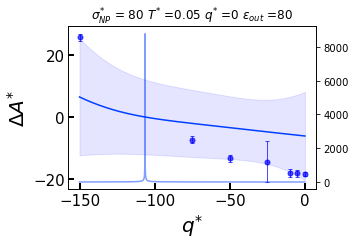

In [88]:
namex=r'$q^{*}$' #'\varepsilon_{in}$'
namey=r'$\Delta A^{*}$'

# normalized values of fixed parameters
#print(processData)
#dataParameters = processData[['sigma', 't', 'q', 'ein', 'eout', 'avgfe', 'sdfe']]
#nDataParameters = standard_scaler.fit_transform(dataParameters)
# sigmaNP: 79, T: 1.000000, q: -1.000004, e_in: 0, e_out: 7932
s=80
s_index=processData[(processData.sigma == s)].index.to_numpy()[0]
s_normalized=normalizedData[s_index][0]

t=0.05
t_index=processData[(processData.t == t)].index.to_numpy()[0]
t_normalized=normalizedData[t_index][1]

#q=0
#q_index=processData[(processData.q == q)].index.to_numpy()[0]
#q_normalized=normalizedData[q_index][2]

ein=80
ein_index=processData[(processData.ein == ein)].index.to_numpy()[0]
ein_normalized=normalizedData[ein_index][3]

eout=80
eout_index=processData[(processData.eout == eout)].index.to_numpy()[0]
eout_normalized=normalizedData[eout_index][4]

nDataParametersDf = pd.DataFrame(normalizedData, columns=['sigma', 't', 'q', 'ein', 'eout', 'avgfe', 'sdfe'])
#print(nDataParametersDf)
plotSet = nDataParametersDf[(nDataParametersDf.sigma == s_normalized)
                       & (nDataParametersDf.t == t_normalized) 
                       & (nDataParametersDf.ein == ein_normalized)
                       & (nDataParametersDf.eout == eout_normalized)]
inverPlotSet = standard_scaler.inverse_transform(plotSet)

plotSetFull = processData[(processData.sigma == s)
                       & (processData.t == t) 
                       & (processData.ein == ein)
                       & (processData.eout == eout)]

X_plotSet = plotSet.to_numpy()

h=0.001
x_min, x_max = X_plotSet[:, 2].min() - h , X_plotSet[:, 2].max() + h
#y_min, y_max = X_plotSet[:, 1].min() , X_plotSet[:, 1].max() #+ 1*h

xx = np.arange(x_min, x_max, h)
#, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Fixed parameters
a=np.ones(np.shape(xx))*s_normalized
b=np.ones(np.shape(xx))*t_normalized
c=np.ones(np.shape(xx))*ein_normalized
d=np.ones(np.shape(xx))*eout_normalized

meshSet = np.c_[a.ravel(), b.ravel(), xx.ravel(), c.ravel(), d.ravel()]
#print(meshSet)

i = 0
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    for batch in np.linspace(1, 3, 3):
        j = int((batch/3)*len(meshSet))
        #print(j)
        #print(meshSet[i:j].shape[0])
        test_noise = torch.zeros(meshSet[i:j].shape[0]).cuda()
        observed_pred = likelihood( model( torch.tensor( meshSet[i:j] ).cuda() ),  learn_additional_noise=True, noise=test_noise)
        #observed_pred = likelihood( model( torch.tensor( meshSet ) ), learn_additional_noise=False)
        lower, upper = observed_pred.confidence_region()
        if batch == 1:
            meanArray = observed_pred.mean.cpu().numpy()
            lowerArray = lower.cpu().numpy()
            upperArray = upper.cpu().numpy()
        else:
            meanArray = np.concatenate( ( meanArray, observed_pred.mean.cpu().numpy() ), axis=0 )
            lowerArray = np.concatenate( ( lowerArray, lower.cpu().numpy() ), axis= 0 )
            upperArray = np.concatenate( ( upperArray, lower.cpu().numpy() ), axis= 0 )

        torch.cuda.empty_cache()
        i = j
        
mean = torch.tensor(meanArray)
lower = torch.tensor(lowerArray)
upper = torch.tensor(upperArray)

#mean = mean.cpu()
#lower = lower.cpu()
#upper = upper.cpu()

Z = mean.numpy().reshape(xx.shape)
Zstd = (mean-lower)#/2
Zstd = Zstd.numpy().reshape(xx.shape)

#Z, Zstd = gprModel.predict(meshSet, return_std=True)

#Z = Z.reshape(xx.shape)
#Zstd = Zstd.reshape(xx.shape)
    

meshSetY = np.c_[a.ravel(), b.ravel(), xx.ravel(), c.ravel(), d.ravel(), Z.ravel(), Zstd.ravel()]
meshSetYmin = np.c_[a.ravel(), b.ravel(), xx.ravel(), c.ravel(), d.ravel(), Z.ravel()-Zstd.ravel(), Zstd.ravel()]
meshSetYmax = np.c_[a.ravel(), b.ravel(), xx.ravel(), c.ravel(), d.ravel(), Z.ravel()+Zstd.ravel(), Zstd.ravel()]

invertMeshSet = standard_scaler.inverse_transform(meshSetY)
invertMeshSetmin = standard_scaler.inverse_transform(meshSetYmin)
invertMeshSetmax = standard_scaler.inverse_transform(meshSetYmax)
invertMeshStd = standard_scaler.inverse_transform(meshSetYmax) - invertMeshSet


fig = plt.figure(figsize=[10,3])
fig.tight_layout(pad=20.0)
fig.subplots_adjust(hspace=.35, wspace=.25)

ax = fig.add_subplot(1, 2, 1)

ax.plot(invertMeshSet[:,2].reshape(xx.shape), invertMeshSet[:,5].reshape(Z.shape))
ax.fill_between(invertMeshSet[:,2].reshape(xx.shape), (invertMeshSetmin[:,5].reshape(Z.shape)), (invertMeshSetmax[:,5].reshape(Z.shape)), color='b', alpha=.1)


ax.errorbar(plotSetFull.q, plotSetFull.avgfe, yerr=plotSetFull.sdfe, c='b',  alpha=0.7,lw=0.,marker='o',markevery=1, elinewidth=1, capsize=2, markersize=5,)
#plt.errorbar(plotSet.sigma, plotSet.avgfe, yerr=plotSet.sdfe, c='b',  alpha=0.7,lw=0.,marker='o',markevery=1, elinewidth=1, capsize=2, markersize=5,)



ax.tick_params(axis="x", labelsize=15, direction='in', length=6, width=2, colors='black')
plt.tick_params(axis="y", labelsize=15, direction='in', length=6, width=2, colors='black')

ax.set_xlabel(namex,fontsize=20)
ax.set_ylabel(namey,fontsize=20)

name=r'$\sigma_{NP}^{*}$ = ' + str(s) + r' $T^{*}$ =' + str(t) + r' $q^{*}$ =' + str(q) + r' $\varepsilon_{out}$ =' + str(eout)

ax.set_title(name)
#plt.savefig('figures-GPR/fe-tqee' + str(t) + '_' + str(q) + '_' + str(ein) + '_' + str(eout) + '.png', bbox_inches = "tight")


#ax = fig.add_subplot(1, 2, 2)
ax2 = ax.twinx()
#ax2.set_title("Acquisition function")
ax2.plot(invertMeshSet[:,2].reshape(xx.shape), invertMeshStd[:,5]/np.abs(invertMeshSet[:,5].reshape(Z.shape) + 0.05), alpha=0.5)
#ax.fill_between(invertMeshSet[:,0].reshape(xx.shape),  invertMeshStd[:,5]/np.abs(invertMeshSetmin[:,5].reshape(Z.shape) + 0.05),  invertMeshStd[:,5]/np.abs(invertMeshSetmax[:,5].reshape(Z.shape) + 0.05), color='b', alpha=.1)

#print(y_plotSet)
#print(processData)

#print(plotSet)
#print(inverPlotSet)
print(normalizedData)
print(processData[(processData.sigma == 80) & (processData.q == -150)])

In [ ]:
#free_energy_array = np.array(free_energy)
free_energy_df = pd.DataFrame(free_energy, columns=["sigma", "t", "q", "ein", "eout", "avg", "sd"])
                
eoname = r'$\varepsilon_{o}$'
einame = r'$\varepsilon_{in}$'
qname = '$q^{*}$'
tname = '$T^{*}$'
sname = '$\sigma_{NP}^{*}$'

names = [sname, tname, qname, einame, eoname]*5
lindex = ['sigma', 't', 'q', 'ein', 'eout']
                         
#fig = plt.figure(figsize=[20,24])
fig = plt.figure(figsize=[30,24])
fig.tight_layout(pad=20.0)
fig.subplots_adjust(hspace=.35, wspace=.25)
#fig.subplots_adjust(hspace=.6, wspace=.5)

k = 1
a = 1
nxsubplots = 7 #6 # len(parameters)/3
nysubplots = 7 #6 3
list_selected = []

        
for i in range(0, len(parameters[k])):
    for j in range(i+1, len(parameters[k])):
            
        for k in range(0, len(parameters)):
                
            name = ''
            free_energy_ij = free_energy_df
            
            #print(free_energy_ij)
            
            sublist_selected = []
            for l in range(0, len(parameters[k])):
                 if l != i and l != j:
                    column = lindex[l]
                    if l < 4:
                        name = name + names[l] + ' = ' + str(parameters[k][l]) + ', '             
                    else:
                        name = name + names[l] + ' = ' + str(parameters[k][l])
                    sublist_selected.append(parameters[k][l])
                    free_energy_ij = free_energy_ij[free_energy_ij[column] == parameters[k][l]]

            #print(free_energy_ij) 
            free_energy_ij_list = np.array(free_energy_ij.values.tolist())
            if len(np.unique(free_energy_ij_list[:,i])) == 1 or len(np.unique(free_energy_ij_list[:,j])) == 1:
                continue
              
            if sublist_selected in list_selected:
                continue
                
            list_selected.append(sublist_selected)
    
            ax = fig.add_subplot(nxsubplots, nysubplots, a)
            #ax = plt.axes(projection='3d')
            sc = plt.scatter(free_energy_ij_list[:,j], free_energy_ij_list[:,i], s=75, c=free_energy_ij_list[:,5], alpha=1, marker='o', cmap = cm.rainbow)
            cb = plt.colorbar(sc)
            
            ax.tick_params(axis="x", labelsize=15, direction='in', length=6, width=2, colors='black')
            ax.tick_params(axis="y", labelsize=15, direction='in', length=6, width=2, colors='black')

            plt.xlabel(names[j],fontsize=20)
            plt.ylabel(names[i],fontsize=20)

            if a%nysubplots == 0:
                cb.set_label(r'$\Delta A$ [$\epsilon T^{*}$]', rotation=270, fontsize=20, labelpad=30)
            cb.ax.tick_params(labelsize=15, pad=10)
    
            plt.clim(np.min(free_energy_ij_list[:,5]), np.max(free_energy_ij_list[:,5]))

            ax.set_title(name, fontsize=20, y=1.05)
            #ax.set_clim(-20, 400)
    
            a += 1
        
print(list_selected)
#label for last subplot
cb.set_label(r'$0\Delta A$ [$\epsilon T^{*}$]', rotation=270, fontsize=20, labelpad=30)
#plt.savefig('figures-slices/free-energy-s80.png', bbox_inches = "tight")

### 2D: sigma and T

In [ ]:
namex=r'$\sigma_{NP}^{*}$'
namey=r'$T^{*}$'

fig = plt.figure(figsize=[30,24])
fig.tight_layout(pad=20.0)
fig.subplots_adjust(hspace=.35, wspace=.25)

nxsubplots = 9 #6 # len(parameters)/3
nysubplots = 9 #6 3
k = 1
sp = 1

for p in parameters[:2]:
                    
    q=float(p[2])
    ein=float(p[3])
    eout=float(p[4])
    
    #print(q)

    q_index=processData[(processData.q == q)].index.to_numpy()[0]
    q_normalized=normalizedData[q_index][2]

    ein_index=processData[(processData.ein == ein)].index.to_numpy()[0]
    ein_normalized=normalizedData[ein_index][3]

    eout_index=processData[(processData.eout == eout)].index.to_numpy()[0]
    eout_normalized=normalizedData[eout_index][4]

    nDataParametersDf = pd.DataFrame(normalizedData, columns=['sigma', 't', 'q', 'ein', 'eout', 'avgfe', 'sdfe'])

    plotSet = nDataParametersDf[(nDataParametersDf.q == q_normalized) 
                       & (nDataParametersDf.ein == ein_normalized)
                       & (nDataParametersDf.eout == eout_normalized)]

    inverPlotSet = standard_scaler.inverse_transform(plotSet)

    X_plotSet = plotSet.to_numpy()

    h=0.02
    x_min, x_max = X_plotSet[:, 0].min() -5*h, X_plotSet[:, 0].max() + 5*h
    y_min, y_max = X_plotSet[:, 1].min() -5*h, X_plotSet[:, 1].max() + 5*h

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Fixed parameters
    a=np.ones(np.shape(xx))*q_normalized
    b=np.ones(np.shape(xx))*ein_normalized
    c=np.ones(np.shape(xx))*eout_normalized

    meshSet = np.c_[xx.ravel(), yy.ravel(), a.ravel(), b.ravel(), c.ravel()]
    

    i = 0
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        for batch in np.linspace(1, 3, 3):
            j = int((batch/3)*len(meshSet))
            #print(j)
            #print(meshSet[i:j].shape[0])
            test_noise = torch.zeros(meshSet[i:j].shape[0]).cuda()
            observed_pred = likelihood( model( torch.tensor( meshSet[i:j] ).cuda() ),  learn_additional_noise=True, noise=test_noise)
            #observed_pred = likelihood( model( torch.tensor( meshSet ) ), learn_additional_noise=False)
            lower, upper = observed_pred.confidence_region()
            if batch == 1:
                meanArray = observed_pred.mean.cpu().numpy()
                lowerArray = lower.cpu().numpy()
                upperArray = upper.cpu().numpy()
            else:
                meanArray = np.concatenate( ( meanArray, observed_pred.mean.cpu().numpy() ), axis=0 )
                lowerArray = np.concatenate( ( lowerArray, lower.cpu().numpy() ), axis= 0 )
                upperArray = np.concatenate( ( upperArray, lower.cpu().numpy() ), axis= 0 )
    
            torch.cuda.empty_cache()
            i = j
            
    mean = torch.tensor(meanArray)
    lower = torch.tensor(lowerArray)
    upper = torch.tensor(upperArray)
    
    #mean = mean.cpu()
    #lower = lower.cpu()
    #upper = upper.cpu()
    
    Z = mean.numpy().reshape(xx.shape)
    Zstd = (mean-lower)/2
    Zstd = Zstd.numpy().reshape(xx.shape)
    

    meshSetY = np.c_[xx.ravel(), yy.ravel(), a.ravel(), b.ravel(), c.ravel(), Z.ravel(), Zstd.ravel()]
    invertMeshSet = standard_scaler.inverse_transform(meshSetY)

    cmap = colors.ListedColormap(['white', 'orange'])
    
    ax = fig.add_subplot(nxsubplots, nysubplots, sp)

    cf = ax.contourf(invertMeshSet[:,0].reshape(xx.shape), invertMeshSet[:,1].reshape(yy.shape), invertMeshSet[:,5].reshape(Z.shape), cmap=plt.cm.coolwarm, alpha=0.8)
    cb = plt.colorbar(cf, orientation='horizontal', pad=0.25)
    #cb = plt.colorbar(cf, orientation='horizontal', ticks=None)
    #plt.scatter(X_plotSetScaled[:, 0], X_plotSetScaled[:,1], c=y_plotSet.to_numpy(), cmap=plt.cm.coolwarm)
    sc = ax.scatter(inverPlotSet[:, 0], inverPlotSet[:,1], c=inverPlotSet[:,-2], cmap=cm.rainbow)
    cb = plt.colorbar(sc)

    ax.set_xlim(inverPlotSet[:, 0].min() -1.85, inverPlotSet[:, 0].max() + 0.75)
    ax.set_ylim(inverPlotSet[:, 1].min() -0.5, inverPlotSet[:, 1].max() + 0.35)

    ax.tick_params(axis="x", labelsize=15, direction='in', length=6, width=2, colors='black')
    ax.tick_params(axis="y", labelsize=15, direction='in', length=6, width=2, colors='black')

    ax.set_xlabel(namex,fontsize=20)
    ax.set_ylabel(namey,fontsize=20)
    
    sp += 1

    name=r' $q^{*}$ =' + str(q) + r' $\varepsilon_{in}$ =' + str(ein) + r' $\varepsilon_{out}$ =' + str(eout)

    plt.title(name)

#plt.savefig('figures-SVM/fe-qee' + str(q) + '_' + str(ein) + '_' + str(eout) + '.png', bbox_inches = "tight")

    #print(y_plotSet)